# Network insights: Walkability and Hierarchical Clustering of London Diverse Urban Services(Code)

In [1]:
!pip install PyPDF2
!pip install psd-tools

In [2]:
import requests
import zipfile
import os
import geopandas as gpd
import pandas as pd
import networkx as nx
from shapely.geometry import Point
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import PyPDF2
import re
import io
from psd_tools import PSDImage
from scipy.stats import mode
import shutil
from shapely.geometry import MultiPolygon
from shapely.ops import unary_union, split
import math

In [3]:
import time
start_time =time.time()

# 1 Introduction

# 2 Literature

# 3 Methodology

## 3.1 Data

### 3.1.1 Administrate District

In [4]:
# 下载并解压缩 Shapefile 数据
r = requests.get("https://github.com/ZuoLiya/Liya-Zuo-Dissertation/raw/b592099ae267eb80d501df974974751c3170a8ad/3.1%20Data/Administrate%20District/London%20Boundary.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("LondonBoundary")

# 读取 Shapefile 数据
LondonBoundary = gpd.read_file("LondonBoundary/London Boundary.shp")
LondonBoundary

NAME         Area                                           geometry
0  London  1573.400741  POLYGON ((531643.600 200802.700, 531658.600 20...

In [5]:
# 使用 GitHub 上的 raw 链接下载 ZIP 文件
StatisticResponse = requests.get("https://github.com/ZuoLiya/Liya-Zuo-Dissertation/raw/0b8434f7b1b8b8164d97af8faf1d40a2e8c91bf8/3.1%20Data/Administrate%20District/statistical-gis-boundaries-london.zip")

# 检查请求是否成功
if StatisticResponse.status_code == 200:
    try:
        # 将内容写入到内存中的文件对象
        zip_file = zipfile.ZipFile(io.BytesIO(StatisticResponse.content))

        # 解压文件到本地目录
        zip_file.extractall("statistical-gis-boundaries-london")
        print("ZIP 文件下载并解压成功。")
    except zipfile.BadZipFile:
        print("下载的文件不是有效的 ZIP 文件。")
else:
    print(f"下载失败，状态码：{StatisticResponse.status_code}")

ZIP 文件下载并解压成功。


#### 3.1.1.1 OA

In [6]:
OA = gpd.read_file("statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/OA_2011_London_gen_MHW.shp")
OA

OA11CD   LSOA11CD   MSOA11CD  WD11CD_BF    WD11NM_BF    LAD11CD  \
0      E00023264  E01004612  E02000954  E05000626      Tooting  E09000032   
1      E00003359  E01000692  E02000128  E05000111  Chislehurst  E09000006   
2      E00023266  E01004615  E02000956  E05000626      Tooting  E09000032   
3      E00020264  E01004027  E02000809  E05000548    Riverside  E09000028   
4      E00023263  E01004613  E02000955  E05000626      Tooting  E09000032   
...          ...        ...        ...        ...          ...        ...   
25048  E00004047  E01000828  E02000137  E05000126   Shortlands  E09000006   
25049  E00007044  E01001420  E02000296  E05000196  Cockfosters  E09000010   
25050  E00003854  E01000791  E02000155  E05000122    Orpington  E09000006   
25051  E00014344  E01002862  E02000590  E05000390    Hans Town  E09000020   
25052  E00175248  E01004731  E02000979  E05000644   St James's  E09000033   

                      LAD11NM    RGN11CD RGN11NM                     LSOA11NM  \
0                  Wandsworth  E12000007  London              Wandsworth 032C   
1                     Bromley  E12000007  London                 Bromley 002D   
2                  Wandsworth  E12000007  London              Wandsworth 034B   
3                   Southwark  E12000007  London               Southwark 003E   
4                  Wandsworth  E12000007  London              Wandsworth 033D   
...                       ...        ...     ...                          ...   
25048                 Bromley  E12000007  London                 Bromley 011E   
25049                 Enfield  E12000007  London                 Enfield 020B   
25050                 Bromley  E12000007  London                 Bromley 029E   
25051  Kensington and Chelsea  E12000007  London  Kensington and Chelsea 014E   
25052             Westminster  E12000007  London             Westminster 020A   

                         MSOA11NM  USUALRES  HHOLDRES  COMESTRES   POPDEN  \
0                  Wandsworth 032       462       459          3    115.2   
1                     Bromley 002       269       259         10     36.7   
2                  Wandsworth 034       277       277          0    183.4   
3                   Southwark 003       415       415          0     96.1   
4                  Wandsworth 033       304       304          0    165.2   
...                           ...       ...       ...        ...      ...   
25048                 Bromley 011       349       349          0     43.7   
25049                 Enfield 020       288       288          0     30.5   
25050                 Bromley 029       284       284          0     32.1   
25051  Kensington and Chelsea 014       452       452          0  22600.0   
25052             Westminster 020       206       206          0  10300.0   

       HHOLDS  AVHHOLDSZ                                           geometry  
0         143        3.2  POLYGON ((527635.452 171810.058, 527495.957 17...  
1         133        1.9  POLYGON ((543581.516 171132.486, 543704.000 17...  
2         133        2.1  POLYGON ((526613.539 171839.165, 526546.840 17...  
3         191        2.2  POLYGON ((533563.521 179695.146, 533351.118 17...  
4         131        2.3  POLYGON ((527822.000 172020.000, 527979.000 17...  
...       ...        ...                                                ...  
25048     117        3.0  POLYGON ((539163.316 168360.071, 539026.000 16...  
25049     114        2.5  POLYGON ((528811.000 195161.000, 528814.206 19...  
25050     126        2.3  POLYGON ((546965.963 166027.878, 546947.923 16...  
25051     384        1.2  POLYGON ((527325.087 178641.434, 527321.728 17...  
25052     110        1.9  POLYGON ((529580.098 179194.237, 529586.108 17...  

[25053 rows x 18 columns]

#### 3.1.1.2 LSOA

In [7]:
LSOA = gpd.read_file("statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp")
LSOA

LSOA11CD                   LSOA11NM   MSOA11CD  \
0     E01000001        City of London 001A  E02000001   
1     E01000002        City of London 001B  E02000001   
2     E01000003        City of London 001C  E02000001   
3     E01000005        City of London 001E  E02000001   
4     E01000006  Barking and Dagenham 016A  E02000017   
...         ...                        ...        ...   
4830  E01033742             Greenwich 007F  E02000319   
4831  E01033743             Greenwich 002H  E02000314   
4832  E01033744             Greenwich 007G  E02000319   
4833  E01033745             Greenwich 002I  E02000314   
4834  E01033746             Greenwich 038E  E02006931   

                      MSOA11NM    LAD11CD               LAD11NM    RGN11CD  \
0           City of London 001  E09000001        City of London  E12000007   
1           City of London 001  E09000001        City of London  E12000007   
2           City of London 001  E09000001        City of London  E12000007   
3           City of London 001  E09000001        City of London  E12000007   
4     Barking and Dagenham 016  E09000002  Barking and Dagenham  E12000007   
...                        ...        ...                   ...        ...   
4830             Greenwich 007  E09000011             Greenwich  E12000007   
4831             Greenwich 002  E09000011             Greenwich  E12000007   
4832             Greenwich 007  E09000011             Greenwich  E12000007   
4833             Greenwich 002  E09000011             Greenwich  E12000007   
4834             Greenwich 038  E09000011             Greenwich  E12000007   

     RGN11NM  USUALRES  HHOLDRES  COMESTRES  POPDEN  HHOLDS  AVHHOLDSZ  \
0     London      1465      1465          0   112.9     876        1.7   
1     London      1436      1436          0    62.9     830        1.7   
2     London      1346      1250         96   227.7     817        1.5   
3     London       985       985          0    52.0     467        2.1   
4     London      1703      1699          4   116.2     543        3.1   
...      ...       ...       ...        ...     ...     ...        ...   
4830  London      1352      1352          0   107.6     581        2.3   
4831  London      2038      2038          0    20.4     663        3.1   
4832  London      1845      1728        117   125.8     646        2.7   
4833  London      1820      1820          0    32.3     591        3.1   
4834  London      1464      1436         28   115.3     715        2.0   

                                               geometry  
0     POLYGON ((532105.092 182011.230, 532162.491 18...  
1     POLYGON ((532746.813 181786.891, 532671.688 18...  
2     POLYGON ((532135.145 182198.119, 532158.250 18...  
3     POLYGON ((533807.946 180767.770, 533649.063 18...  
4     POLYGON ((545122.049 184314.931, 545271.917 18...  
...                                                 ...  
4830  POLYGON ((544642.680 179824.674, 544766.313 17...  
4831  POLYGON ((546579.195 181097.813, 546687.036 18...  
4832  POLYGON ((544536.486 179447.115, 544602.630 17...  
4833  POLYGON ((546415.745 180152.270, 546320.715 18...  
4834  POLYGON ((538140.000 177313.000, 538129.177 17...  

[4835 rows x 15 columns]

#### 3.1.1.3 MSOA

In [8]:
MSOA = gpd.read_file("statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp")
MSOA

MSOA11CD                  MSOA11NM    LAD11CD               LAD11NM  \
0    E02000001        City of London 001  E09000001        City of London   
1    E02000002  Barking and Dagenham 001  E09000002  Barking and Dagenham   
2    E02000003  Barking and Dagenham 002  E09000002  Barking and Dagenham   
3    E02000004  Barking and Dagenham 003  E09000002  Barking and Dagenham   
4    E02000005  Barking and Dagenham 004  E09000002  Barking and Dagenham   
..         ...                       ...        ...                   ...   
978  E02006927             Greenwich 034  E09000011             Greenwich   
979  E02006928             Greenwich 035  E09000011             Greenwich   
980  E02006929             Greenwich 036  E09000011             Greenwich   
981  E02006930             Greenwich 037  E09000011             Greenwich   
982  E02006931             Greenwich 038  E09000011             Greenwich   

       RGN11CD RGN11NM  USUALRES  HHOLDRES  COMESTRES  POPDEN  HHOLDS  \
0    E12000007  London      7375      7187        188    25.5    4385   
1    E12000007  London      6775      6724         51    31.3    2713   
2    E12000007  London     10045     10033         12    46.9    3834   
3    E12000007  London      6182      5937        245    24.8    2318   
4    E12000007  London      8562      8562          0    72.1    3183   
..         ...     ...       ...       ...        ...     ...     ...   
978  E12000007  London      8315      8241         74    33.0    3338   
979  E12000007  London      7341      6410        931   136.0    2977   
980  E12000007  London      7490      7489          1    29.4    3333   
981  E12000007  London      6561      6557          4    75.6    2876   
982  E12000007  London      9186      8973        213    46.1    4113   

     AVHHOLDSZ                                           geometry  
0          1.6  MULTIPOLYGON (((531667.624 180534.992, 531647....  
1          2.5  POLYGON ((548881.563 190845.265, 548881.125 19...  
2          2.6  POLYGON ((549102.438 189324.625, 548954.500 18...  
3          2.6  POLYGON ((551549.998 187364.637, 551478.000 18...  
4          2.7  POLYGON ((549099.634 187656.076, 549161.375 18...  
..         ...                                                ...  
978        2.5  POLYGON ((541029.881 176265.023, 541101.997 17...  
979        2.2  MULTIPOLYGON (((538300.370 177956.632, 538290....  
980        2.2  POLYGON ((540054.366 179353.136, 540220.352 17...  
981        2.3  POLYGON ((539552.478 178604.042, 539533.000 17...  
982        2.2  POLYGON ((538834.754 177736.770, 538880.250 17...  

[983 rows x 13 columns]

#### 3.1.1.4 Borough

In [9]:
Borough = gpd.read_file("statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")
Borough

NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER  \
0     Kingston upon Thames  E09000021   3726.117       0.000         F   
1                  Croydon  E09000008   8649.441       0.000         F   
2                  Bromley  E09000006  15013.487       0.000         F   
3                 Hounslow  E09000018   5658.541      60.755         F   
4                   Ealing  E09000009   5554.428       0.000         F   
5                 Havering  E09000016  11445.735     210.763         F   
6               Hillingdon  E09000017  11570.063       0.000         F   
7                   Harrow  E09000015   5046.330       0.000         F   
8                    Brent  E09000005   4323.270       0.000         F   
9                   Barnet  E09000003   8674.837       0.000         F   
10                 Lambeth  E09000022   2724.940      43.927         T   
11               Southwark  E09000028   2991.340     105.139         T   
12                Lewisham  E09000023   3531.706      16.795         T   
13               Greenwich  E09000011   5044.190     310.785         F   
14                  Bexley  E09000004   6428.649     370.619         F   
15                 Enfield  E09000010   8220.025       0.000         F   
16          Waltham Forest  E09000031   3880.793       0.000         F   
17               Redbridge  E09000026   5644.225       2.300         F   
18                  Sutton  E09000029   4384.698       0.000         F   
19    Richmond upon Thames  E09000027   5876.111     135.443         F   
20                  Merton  E09000024   3762.466       0.000         F   
21              Wandsworth  E09000032   3522.022      95.600         T   
22  Hammersmith and Fulham  E09000013   1715.409      75.648         T   
23  Kensington and Chelsea  E09000020   1238.379      25.994         T   
24             Westminster  E09000033   2203.005      54.308         T   
25                  Camden  E09000007   2178.932       0.000         T   
26           Tower Hamlets  E09000030   2157.501     179.707         T   
27               Islington  E09000019   1485.664       0.000         T   
28                 Hackney  E09000012   1904.902       0.000         T   
29                Haringey  E09000014   2959.837       0.000         T   
30                  Newham  E09000025   3857.806     237.637         T   
31    Barking and Dagenham  E09000002   3779.934     169.150         F   
32          City of London  E09000001    314.942      24.546         T   

    SUB_2009  SUB_2006                                           geometry  
0        NaN       NaN  POLYGON ((516401.600 160201.800, 516407.300 16...  
1        NaN       NaN  POLYGON ((535009.200 159504.700, 535005.500 15...  
2        NaN       NaN  POLYGON ((540373.600 157530.400, 540361.200 15...  
3        NaN       NaN  POLYGON ((521975.800 178100.000, 521967.700 17...  
4        NaN       NaN  POLYGON ((510253.500 182881.600, 510249.900 18...  
5        NaN       NaN  POLYGON ((549893.900 181459.800, 549894.600 18...  
6        NaN       NaN  POLYGON ((510599.800 191689.500, 510615.200 19...  
7        NaN       NaN  POLYGON ((510599.800 191689.500, 510660.000 19...  
8        NaN       NaN  POLYGON ((525201.000 182512.600, 525181.500 18...  
9        NaN       NaN  POLYGON ((524579.900 198355.200, 524594.300 19...  
10       NaN       NaN  POLYGON ((530046.800 177893.400, 530048.400 17...  
11       NaN       NaN  POLYGON ((531335.600 180529.500, 531337.700 18...  
12       NaN       NaN  POLYGON ((536691.000 178958.600, 536691.900 17...  
13       NaN       NaN  MULTIPOLYGON (((537238.700 178137.700, 537242....  
14       NaN       NaN  POLYGON ((547226.200 181299.300, 547320.900 18...  
15       NaN       NaN  POLYGON ((531023.500 200933.600, 531039.900 20...  
16       NaN       NaN  POLYGON ((539923.100 191863.100, 539928.100 19...  
17       NaN       NaN  POLYGON ((543595.500 184832.800, 543577.100 18...  
18       NaN       NaN  POLYGON ((528552.300 159658.100, 5283

#### 3.1.1.5 Borough - MSOA - LSOA- OA Hierarchy

In [10]:
MSOA_counts = OA.groupby('LAD11CD')['MSOA11CD'].nunique().reset_index(name='MSOA_Counts')
LSOA_counts = OA.groupby('LAD11CD')['LSOA11CD'].nunique().reset_index(name='LSOA_Counts')
OA_counts = OA.groupby('LAD11CD')['OA11CD'].nunique().reset_index(name='OA_Counts')

OA_LSOA_MSOA = MSOA_counts.merge(LSOA_counts, on='LAD11CD').merge(OA_counts, on='LAD11CD')

OA_LSOA_MSOA_Borough = pd.merge(OA_LSOA_MSOA, Borough[['GSS_CODE', 'NAME']], left_on='LAD11CD', right_on='GSS_CODE', how='right')
OA_LSOA_MSOA_Borough.drop(columns=['GSS_CODE'], inplace=True)
OA_LSOA_MSOA_Borough = OA_LSOA_MSOA_Borough.sort_values(by=['MSOA_Counts', 'LSOA_Counts', 'OA_Counts'], ascending=False)
OA_LSOA_MSOA_Borough

LAD11CD  MSOA_Counts  LSOA_Counts  OA_Counts                    NAME
1   E09000008           44          220       1132                 Croydon
9   E09000003           41          211       1036                  Barnet
2   E09000006           39          197       1020                 Bromley
4   E09000009           39          196        956                  Ealing
21  E09000032           37          179        982              Wandsworth
30  E09000025           37          164        810                  Newham
15  E09000010           36          183        905                 Enfield
12  E09000023           36          169        887                Lewisham
29  E09000014           36          145        753                Haringey
10  E09000022           35          178        966                 Lambeth
8   E09000005           34          173        829                   Brent
11  E09000028           33          166        893               Southwark
13  E09000011           33          151        809               Greenwich
6   E09000017           32          161        789              Hillingdon
26  E09000030           32          144        748           Tower Hamlets
17  E09000026           31          161        776               Redbridge
5   E09000016           30          150        754                Havering
7   E09000015           30          137        642                  Harrow
14  E09000004           28          146        728                  Bexley
28  E09000012           28          144        749                 Hackney
16  E09000031           28          144        732          Waltham Forest
3   E09000018           28          142        714                Hounslow
25  E09000007           28          133        749                  Camden
20  E09000024           25          124        643                  Merton
22  E09000013           25          113        625  Hammersmith and Fulham
24  E09000033           24          128        783             Westminster
18  E09000029           24          121        616                  Sutton
27  E09000019           23          123        697               Islington
19  E09000027           23          115        615    Richmond upon Thames
31  E09000002           22          110        553    Barking and Dagenham
23  E09000020           21          103        631  Kensington and Chelsea
0   E09000021           20           98        500    Kingston upon Thames
32  E09000001            1            6         31          City of London

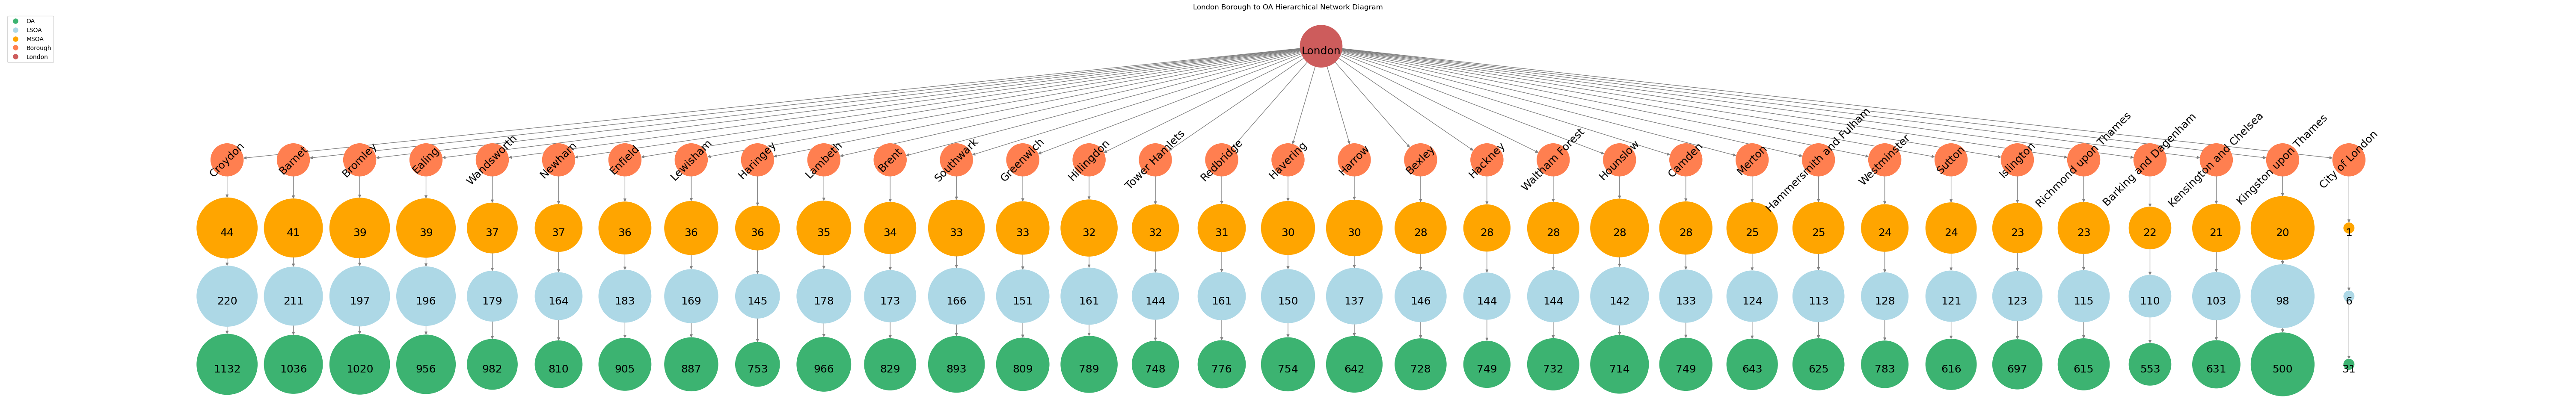

In [11]:
G = nx.DiGraph()

for idx, row in OA_LSOA_MSOA_Borough.iterrows():
    oa_node = f"OA_{idx}_{row['OA_Counts']}"
    lsoa_node = f"LSOA_{idx}_{row['LSOA_Counts']}"
    msoa_node = f"MSOA_{idx}_{row['MSOA_Counts']}"
    
    G.add_edge("London", row['NAME'])  # 从 London 到 LAD (Borough)
    G.add_edge(row['NAME'], msoa_node)  # 从 LAD (Borough) 到 MSOA
    G.add_edge(msoa_node, lsoa_node)  # 从 MSOA 到 LSOA
    G.add_edge(lsoa_node, oa_node)  # 从 LSOA 到 OA


oa_sizes = OA_LSOA_MSOA_Borough['OA_Counts'].values
scaling_factor = 10  # 调整点大小的比例因子
node_size = []

for node in G.nodes():
    if node.startswith(('OA_', 'LSOA_', 'MSOA_', 'LAD_')):
        idx = int(node.split('_')[1])
        size = oa_sizes[idx] * scaling_factor
        node_size.append(size)
    else:
        node_size.append(3000 if node != 'London' else 5000)  # 为 Borough 和 London 设置固定大小

# 调整箭头大小，使其不至于过大影响整体观感
arrowsize = 10

# 修正颜色映射
layer_colors = {"OA": "mediumseagreen", "LSOA": "lightblue", "MSOA": "orange", "Borough": "coral", "London": "indianred"}

# 正确分配节点颜色
node_color = []
for node in G.nodes():
    if node.startswith('OA_'):
        node_color.append(layer_colors["OA"])
    elif node.startswith('LSOA_'):
        node_color.append(layer_colors["LSOA"])
    elif node.startswith('MSOA_'):
        node_color.append(layer_colors["MSOA"])
    elif node == "London":
        node_color.append(layer_colors["London"])
    else:
        node_color.append(layer_colors["Borough"])

# 创建自定义布局，将节点分层放置，并按从大到小排序（前3层），保持第4、5层与上一层一致
layers = [
    ["London"],  # 第一层
    [node for node in G.nodes() if not node.startswith(('OA_', 'LSOA_', 'MSOA_')) and node != "London"],  # 第二层 (Borough NAME)
    sorted([node for node in G.nodes() if node.startswith('MSOA_')], key=lambda x: int(x.split('_')[-1]), reverse=True),  # 第三层 (MSOA_Counts) 按从大到小排序
    [node for node in G.nodes() if node.startswith('LSOA_')],  # 第四层 (LSOA_Counts) 与上一层顺序保持一致
    [node for node in G.nodes() if node.startswith('OA_')]  # 第五层 (OA_Counts) 与上一层顺序保持一致
]

pos = {}
for i, layer in enumerate(layers):
    # 调整节点间距，使得每层之间更加紧凑
    for j, node in enumerate(layer):
        pos[node] = (j, -i * 1.5)  # 通过缩小 -i * 1.5 缩短层与层之间的距离

# 手动调整 London 的位置在顶部中心
pos["London"] = (len(layers[1]) / 2, 1)

# 绘制图形
plt.figure(figsize=(60, 9))  # 调整图形的大小，使得整体布局更紧凑
nx.draw(G, pos, with_labels=False, node_size=node_size, node_color=node_color, font_size=10, font_weight='bold',
        edge_color='gray', verticalalignment='top', arrows=True, arrowstyle='-|>', arrowsize=arrowsize,
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# 手动添加标签
labels = {}
for node in G.nodes():
    if 'OA_' in node or 'LSOA_' in node or 'MSOA_' in node:
        labels[node] = node.split('_')[-1]
    else:
        labels[node] = node


# 一次性绘制所有标签
text_items = nx.draw_networkx_labels(G, pos, labels=labels, font_size=18, verticalalignment='top')

# 手动旋转第二层 Borough 标签，并居中对齐
for node, t in text_items.items():
    if node in layers[1]:  # 仅旋转第二层的标签
        t.set_rotation(45)
        t.set_horizontalalignment('center')  # 水平居中对齐
        t.set_verticalalignment('center')    # 垂直居中对齐

# 添加图例
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='OA', markersize=10, markerfacecolor='mediumseagreen'),
                    plt.Line2D([0], [0], marker='o', color='w', label='LSOA', markersize=10, markerfacecolor='lightblue'),
                    plt.Line2D([0], [0], marker='o', color='w', label='MSOA', markersize=10, markerfacecolor='orange'),
                    plt.Line2D([0], [0], marker='o', color='w', label='Borough', markersize=10, markerfacecolor='coral'),
                    plt.Line2D([0], [0], marker='o', color='w', label='London', markersize=10, markerfacecolor='indianred')],
           loc='upper left')

plt.title("London Borough to OA Hierarchical Network Diagram")
plt.savefig('10-3 Study Area and Data/London Borough to OA Hierarchical Network Diagram.png', dpi=300, bbox_inches='tight')  # 调整分辨率和边界
plt.show()

### 3.1.2 Service POl

In [12]:
# 下载并保存 .zip 文件
POIurl = "https://github.com/ZuoLiya/Liya-Zuo-Dissertation/raw/0a733721489cab37842afb77f4cf9f464580eaf8/3.1%20Data/Reclassfied%20London%20Service%20POI.zip"
POIzip_path = "Reclassfied_London_Service_POI.zip"

POIresponse = requests.get(POIurl, stream=True)
POIresponse.raise_for_status()
with open(POIzip_path, 'wb') as file:
    file.write(POIresponse.content)

# 解压并读取 SHP 文件到 GeoDataFrame
with zipfile.ZipFile(POIzip_path, 'r') as zip_ref:
    zip_ref.extractall("shapefiles")

shp_files = [f for f in os.listdir("shapefiles") if f.endswith('.shp')]

POIgdfs = {os.path.splitext(f)[0]: gpd.read_file(os.path.join("shapefiles", f)) for f in shp_files}

# 输出每个 GeoDataFrame 的 info
for name, gdf in POIgdfs.items():
    print(f"Info for GeoDataFrame: {name}")
    gdf.info()
    print("\n")

Info for GeoDataFrame: DPS
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10551 entries, 0 to 10550
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ref_no      10551 non-null  int64   
 1   name        10551 non-null  object  
 2   pointx_cla  10551 non-null  object  
 3   groupname   10551 non-null  object  
 4   categoryna  10551 non-null  object  
 5   classname   10551 non-null  object  
 6   feature_ea  10551 non-null  float64 
 7   feature_no  10551 non-null  float64 
 8   pos_accura  10551 non-null  int64   
 9   uprn        9730 non-null   object  
 10  topo_toid   10551 non-null  object  
 11  topo_toid_  10551 non-null  int64   
 12  usrn        10551 non-null  object  
 13  usrn_mi     10551 non-null  int64   
 14  distance    10551 non-null  float64 
 15  address_de  10347 non-null  object  
 16  street_nam  10329 non-null  object  
 17  locality    10550 non-null  object  
 18  geographic 

In [13]:
# 初始化总行数为 0
total_rows = 0

# 遍历每个 GeoDataFrame，计算行数并累加总行数
for name, gdf in POIgdfs.items():
    row_count = len(gdf)
    total_rows += row_count
    print(f"London is served by {row_count} {name} POIs.")

# 输出所有 GeoDataFrame 的总行数
print(f"London is served by {total_rows} POIs as a total")

London is served by 10551 DPS POIs.
London is served by 53928 DS POIs.
London is served by 5801 EdS POIs.
London is served by 29550 EnF POIs.
London is served by 12294 FS POIs.
London is served by 11144 HouS POIs.
London is served by 10273 HS POIs.
London is served by 996 PCS POIs.
London is served by 10687 RS POIs.
London is served by 30814 TLS POIs.
London is served by 176038 POIs as a total


#### 3.1.2.1 LSOA Level POI Count

In [14]:
# 假设 'LSOA.shp' 是 LSOA 对应的 shapefile，读取 LSOA 数据
LSOA_counts = LSOA.copy()  # 复制 LSOA GeoDataFrame

# 对每个 POI GeoDataFrame 进行空间连接，并计算在每个 LSOA 中的数量
for name, gdf in POIgdfs.items():
    if name != 'LSOA':
        # 进行空间连接，找到每个 POI 点在哪个 LSOA 中
        joined_gdf = gpd.sjoin(gdf, LSOA_counts, how='inner', op='within')
        
        # 按 LSOA 分组计数
        counts = joined_gdf.groupby('LSOA11CD').size()  # 假设 'LSOA11CD' 是 LSOA 的唯一标识符
        
        # 将计数结果添加到 LSOA GeoDataFrame 中
        LSOA_counts[name + '_count'] = LSOA_counts['LSOA11CD'].map(counts).fillna(0)

# 假设最后十列是你需要求和的列
last_ten_columns = LSOA_counts.columns[-10:]

# 计算最后十列的总和并添加为新的列 'POI_count'
LSOA_counts['POI_count'] = LSOA_counts[last_ten_columns].sum(axis=1)

# 输出 LSOA_counts 以查看结果
LSOA_counts

/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_30151/2036059538.py:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...

  joined_gdf = gpd.sjoin(gdf, LSOA_counts, how='inner', op='within')
/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_30151/2036059538.py:8: UserWarning: CRS mismatch between the CRS of left geo

LSOA11CD                   LSOA11NM   MSOA11CD  \
0     E01000001        City of London 001A  E02000001   
1     E01000002        City of London 001B  E02000001   
2     E01000003        City of London 001C  E02000001   
3     E01000005        City of London 001E  E02000001   
4     E01000006  Barking and Dagenham 016A  E02000017   
...         ...                        ...        ...   
4830  E01033742             Greenwich 007F  E02000319   
4831  E01033743             Greenwich 002H  E02000314   
4832  E01033744             Greenwich 007G  E02000319   
4833  E01033745             Greenwich 002I  E02000314   
4834  E01033746             Greenwich 038E  E02006931   

                      MSOA11NM    LAD11CD               LAD11NM    RGN11CD  \
0           City of London 001  E09000001        City of London  E12000007   
1           City of London 001  E09000001        City of London  E12000007   
2           City of London 001  E09000001        City of London  E12000007   
3           City of London 001  E09000001        City of London  E12000007   
4     Barking and Dagenham 016  E09000002  Barking and Dagenham  E12000007   
...                        ...        ...                   ...        ...   
4830             Greenwich 007  E09000011             Greenwich  E12000007   
4831             Greenwich 002  E09000011             Greenwich  E12000007   
4832             Greenwich 007  E09000011             Greenwich  E12000007   
4833             Greenwich 002  E09000011             Greenwich  E12000007   
4834             Greenwich 038  E09000011             Greenwich  E12000007   

     RGN11NM  USUALRES  HHOLDRES  ...  DS_count  EdS_count  EnF_count  \
0     London      1465      1465  ...      21.0        0.0       40.0   
1     London      1436      1436  ...      30.0        2.0       43.0   
2     London      1346      1250  ...       9.0        1.0       11.0   
3     London       985       985  ...      88.0        0.0       27.0   
4     London      1703      1699  ...       0.0        0.0        1.0   
...      ...       ...       ...  ...       ...        ...        ...   
4830  London      1352      1352  ...       0.0        0.0        0.0   
4831  London      2038      2038  ...       3.0        0.0        5.0   
4832  London      1845      1728  ...       4.0        0.0        1.0   
4833  London      1820      1820  ...       1.0        3.0        1.0   
4834  London      1464      1436  ...       3.0        0.0        5.0   

      FS_count HouS_count  HS_count  PCS_count  RS_count  TLS_count  POI_count  
0          5.0        3.0       6.0        0.0       1.0       15.0       95.0  
1         17.0        3.0       8.0        0.0       4.0       12.0      135.0  
2          2.0        2.0       3.0        0.0       0.0        1.0       31.0  
3          7.0        6.0       6.0        0.0       5.0       22.0      174.0  
4          0.0        1.0       0.0        0.0       0.0        1.0        3.0  
...        ...        ...       ...        ...       ...        ...        ...  
4830       0.0        0.0       0.0        0.0       0.0        4.0        4.0  
4831       4.0        3.0       1.0        1.0       5.0        4.0       30.0  
4832       2.0        0.0       4.0        0.0       0.0        4.0       15.0  
4833       0.0        1.0       3.0        0.0       0.0        9.0       23.0  
4834       0.0        2.0       3.0        0.0       0.0        6.0       19.0  

[4835 rows x 26 columns]

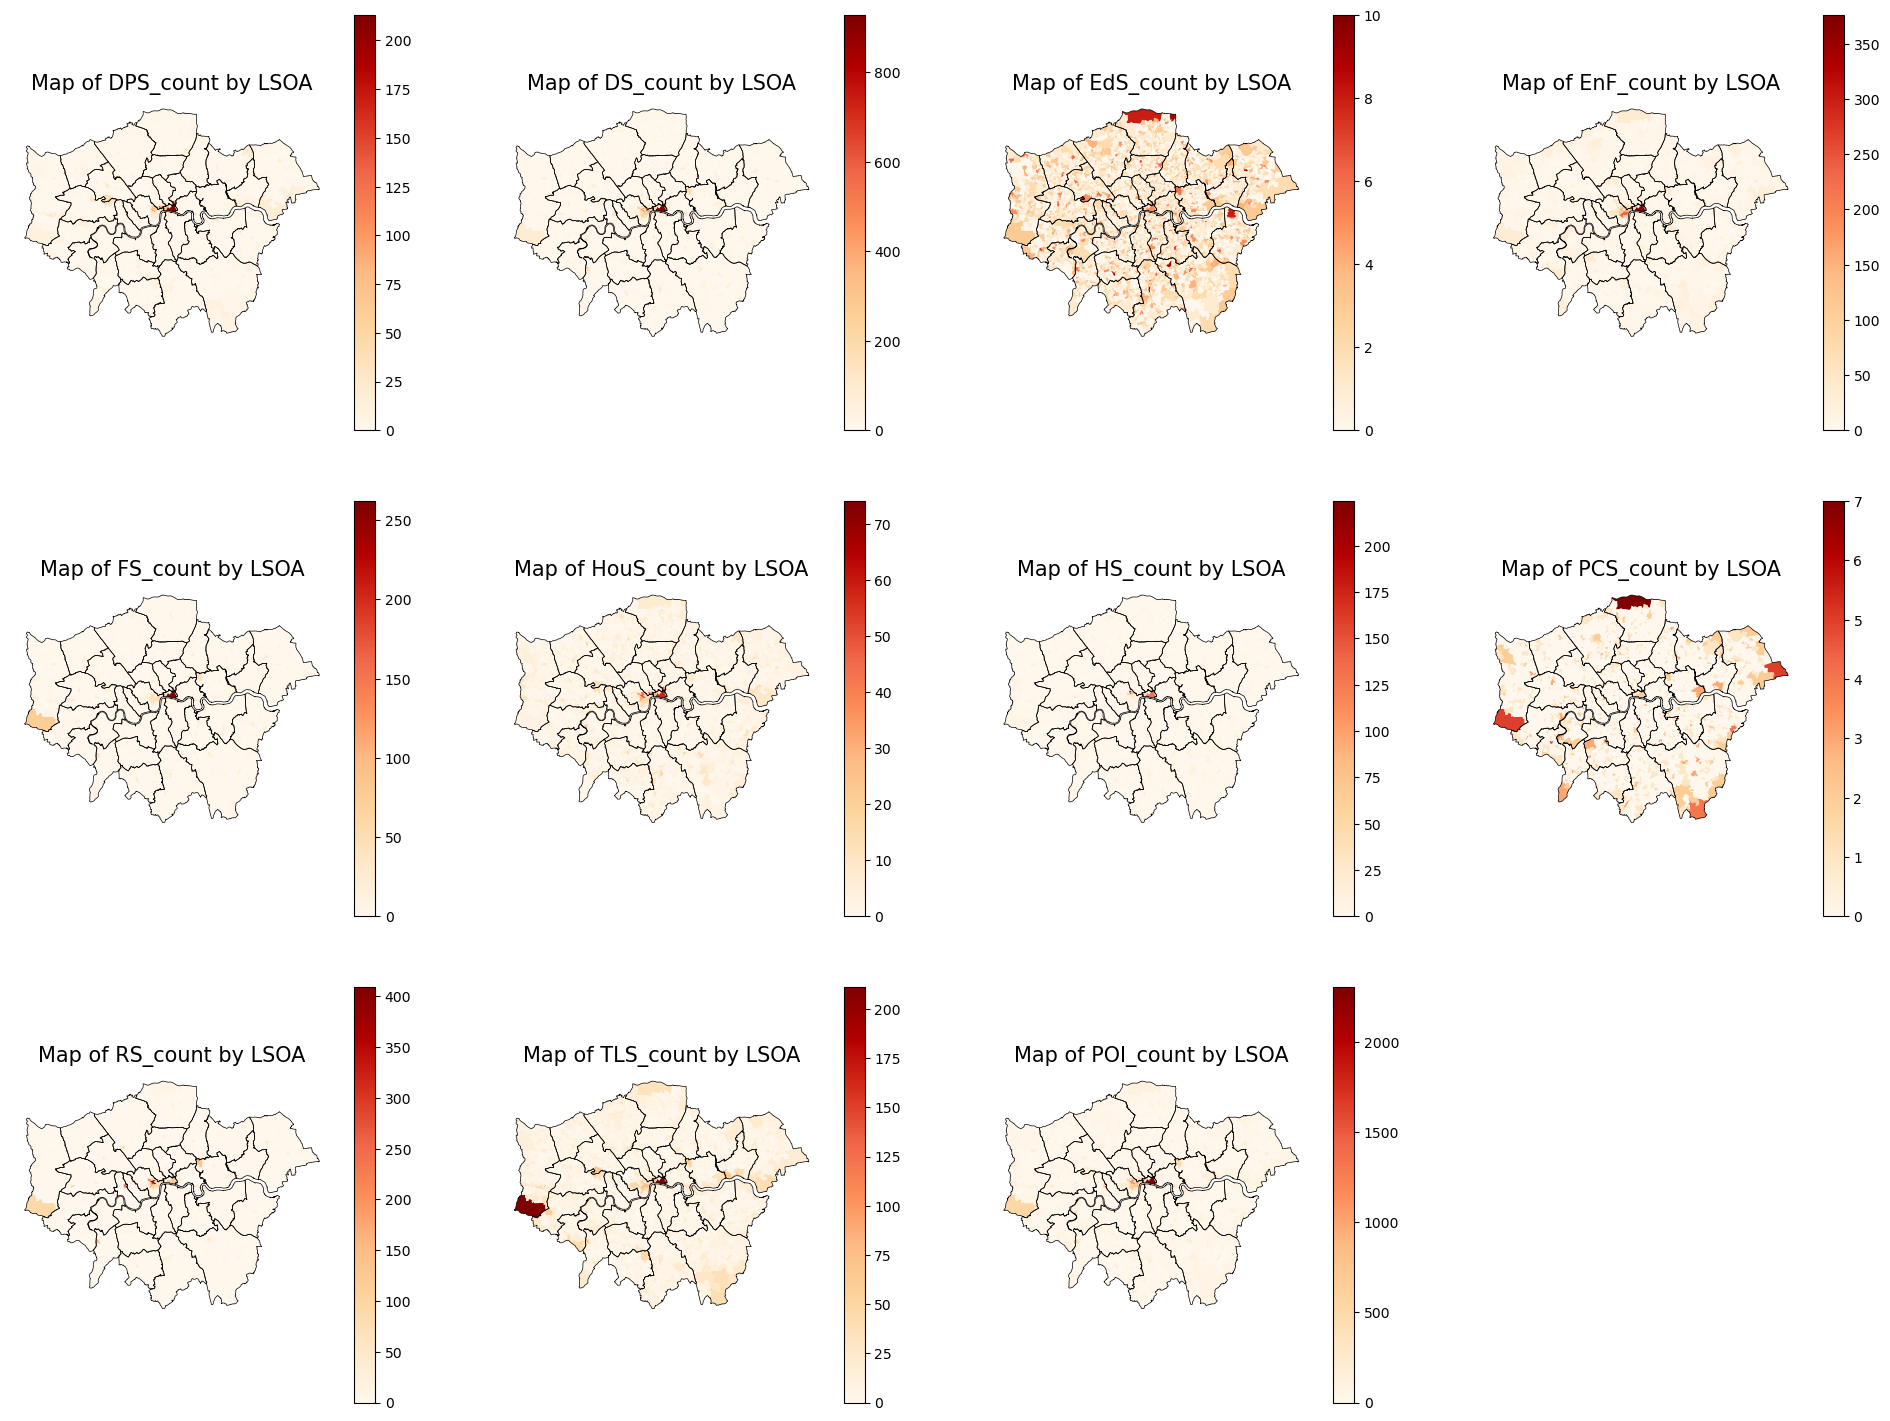

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 假设 LSOA_counts 和 Borough 是已经加载的 GeoDataFrame

# 获取 LSOA_counts 最后 11 列的列名
last_eleven_columns = LSOA_counts.columns[-11:]

# 创建 3x4 的子图布局，但只使用 11 个子图
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

# 调整布局，以适应标题和图例
fig.tight_layout(pad=3.0)

# 扁平化 axes 数组，便于逐个访问
axes = axes.flatten()

# 为每一列生成一个地图
for i, column in enumerate(last_eleven_columns):
    # 绘制 LSOA_counts 的当前列，使用不同的颜色映射
    LSOA_counts.plot(column=column, ax=axes[i], legend=True, cmap='OrRd', edgecolor='none')
    
    # 叠加 Borough 的边界
    Borough.boundary.plot(ax=axes[i], linewidth=0.5, color='black')
    
    # 设置图标题
    axes[i].set_title(f"Map of {column} by LSOA", fontsize=15)
    
    # 隐藏坐标轴
    axes[i].set_axis_off()

# 移除多余的子图（仅在最后几张图未占满整个布局时才需要）
for j in range(len(last_eleven_columns), len(axes)):
    fig.delaxes(axes[j])

# 显示整体图形
plt.show()

In [16]:
# 获取最后 11 列的列名
last_eleven_columns = LSOA_counts.columns[-11:]

# 初始化一个字典，用于存储结果
results = {}

# 遍历最后 11 列，找到最大值、最小值、众数及其对应行的信息
for column in last_eleven_columns:
    # 找到当前列的最大值和最小值
    max_value = LSOA_counts[column].max()
    min_value = LSOA_counts[column].min()
    
    # 获取众数
    mode_result = mode(LSOA_counts[column], nan_policy='omit')
    
    # 检查众数是否为有效值
    if isinstance(mode_result.count, np.ndarray) and mode_result.count.size > 0:
        mode_value = mode_result.mode[0]
        mode_count = mode_result.count[0]
    else:
        mode_value = 0  # 如果众数为0，显式地设置为0
        mode_count = 0
    
    # 找到最大值和最小值所在的所有行
    max_rows = LSOA_counts[LSOA_counts[column] == max_value]
    min_rows = LSOA_counts[LSOA_counts[column] == min_value]
    
    # 获取最大值和最小值所在行的数量
    max_count = max_rows.shape[0]
    min_count = min_rows.shape[0]
    
    # 初始化结果字典
    results[column] = {
        'max_value': max_value,
        'max_count': max_count,
        'min_value': min_value,
        'min_count': min_count,
        'mode_value': mode_value,
        'mode_count': mode_count
    }

    # 如果最大值所在行数小于 5，则输出详细信息
    if max_count < 5:
        results[column]['max_info'] = [
            {
                'LSOA11NM': row['LSOA11NM'],
                'MSOA11NM': row['MSOA11NM'],
                'LAD11NM': row['LAD11NM']
            } for _, row in max_rows.iterrows()
        ]
    
    # 如果最小值所在行数小于 5，则输出详细信息
    if min_count < 5:
        results[column]['min_info'] = [
            {
                'LSOA11NM': row['LSOA11NM'],
                'MSOA11NM': row['MSOA11NM'],
                'LAD11NM': row['LAD11NM']
            } for _, row in min_rows.iterrows()
        ]

# 输出结果
for column, result in results.items():
    print(f"Column: {column}")
    
    # 输出最大值信息
    print(f"  Max Value: {result['max_value']} (Number of rows: {result['max_count']})")
    if result['max_count'] < 5:
        for info in result.get('max_info', []):
            print(f"    (LSOA11NM: {info['LSOA11NM']}, MSOA11NM: {info['MSOA11NM']}, LAD11NM: {info['LAD11NM']})")
    
    # 输出最小值信息
    print(f"  Min Value: {result['min_value']} (Number of rows: {result['min_count']})")
    if result['min_count'] < 5:
        for info in result.get('min_info', []):
            print(f"    (LSOA11NM: {info['LSOA11NM']}, MSOA11NM: {info['MSOA11NM']}, LAD11NM: {info['LAD11NM']})")
    
    # 输出众数信息
    if result['mode_value'] == 0:
        print(f"  Mode Value: 0")
    else:
        print(f"  Mode Value: {result['mode_value']} (Number of rows: {result['mode_count']})")
    
    print("\n")

Column: DPS_count
  Max Value: 213.0 (Number of rows: 1)
    (LSOA11NM: City of London 001F, MSOA11NM: City of London 001, LAD11NM: City of London)
  Min Value: 0.0 (Number of rows: 1875)
  Mode Value: 0


Column: DS_count
  Max Value: 928.0 (Number of rows: 1)
    (LSOA11NM: City of London 001F, MSOA11NM: City of London 001, LAD11NM: City of London)
  Min Value: 0.0 (Number of rows: 1096)
  Mode Value: 0


Column: EdS_count
  Max Value: 10.0 (Number of rows: 1)
    (LSOA11NM: Croydon 027B, MSOA11NM: Croydon 027, LAD11NM: Croydon)
  Min Value: 0.0 (Number of rows: 1804)
  Mode Value: 0


Column: EnF_count
  Max Value: 376.0 (Number of rows: 1)
    (LSOA11NM: City of London 001F, MSOA11NM: City of London 001, LAD11NM: City of London)
  Min Value: 0.0 (Number of rows: 403)
  Mode Value: 0


Column: FS_count
  Max Value: 262.0 (Number of rows: 1)
    (LSOA11NM: City of London 001F, MSOA11NM: City of London 001, LAD11NM: City of London)
  Min Value: 0.0 (Number of rows: 1968)
  Mode Value:

In [17]:
# 选择 LSOA_counts 的第 16 到 25 列（索引为 15 到 24）
selected_columns_sums = LSOA_counts.iloc[:, 15:25].sum()
# 选择 LSOA_counts 的第 16 到 25 列（索引为 15 到 24）
total_sum_columns_16_to_25 = LSOA_counts.iloc[:, 15:25].values.sum()

# 输出结果
for column_name, column_sum in selected_columns_sums.items():
    print(f"The sum of {column_name} is: {column_sum}")

print(f"The total sum of service POI within in LSOA_counts is: {total_sum_columns_16_to_25}")

The sum of DPS_count is: 10241.0
The sum of DS_count is: 53008.0
The sum of EdS_count is: 5627.0
The sum of EnF_count is: 28394.0
The sum of FS_count is: 12017.0
The sum of HouS_count is: 10750.0
The sum of HS_count is: 10022.0
The sum of PCS_count is: 940.0
The sum of RS_count is: 10546.0
The sum of TLS_count is: 29026.0
The total sum of service POI within in LSOA_counts is: 170571.0


#### 3.1.2.2 Borough Level POI Count

In [18]:
# 假设 'LSOA.shp' 是 LSOA 对应的 shapefile，读取 LSOA 数据
Borough_counts = Borough.copy()  # 复制 LSOA GeoDataFrame

# 对每个 POI GeoDataFrame 进行空间连接，并计算在每个 LSOA 中的数量
for name, gdf in POIgdfs.items():
    if name != 'NAME':
        # 进行空间连接，找到每个 POI 点在哪个 LSOA 中
        joined_gdf = gpd.sjoin(gdf, Borough_counts, how='inner', op='within')
        
        # 按 LSOA 分组计数
        counts = joined_gdf.groupby('NAME').size()  # 假设 'LSOA11CD' 是 LSOA 的唯一标识符
        
        # 将计数结果添加到 LSOA GeoDataFrame 中
        Borough_counts[name + '_count'] = Borough_counts['NAME'].map(counts).fillna(0)

# 假设最后十列是你需要求和的列
last_ten_columns = Borough_counts.columns[-10:]

# 计算最后十列的总和并添加为新的列 'POI_count'
Borough_counts['POI_count'] = Borough_counts[last_ten_columns].sum(axis=1)

# 输出 LSOA_counts 以查看结果
Borough_counts

/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_30151/2254045242.py:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...

  joined_gdf = gpd.sjoin(gdf, Borough_counts, how='inner', op='within')
/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_30151/2254045242.py:8: UserWarning: CRS mismatch between the CRS of left 

NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER  \
0     Kingston upon Thames  E09000021   3726.117       0.000         F   
1                  Croydon  E09000008   8649.441       0.000         F   
2                  Bromley  E09000006  15013.487       0.000         F   
3                 Hounslow  E09000018   5658.541      60.755         F   
4                   Ealing  E09000009   5554.428       0.000         F   
5                 Havering  E09000016  11445.735     210.763         F   
6               Hillingdon  E09000017  11570.063       0.000         F   
7                   Harrow  E09000015   5046.330       0.000         F   
8                    Brent  E09000005   4323.270       0.000         F   
9                   Barnet  E09000003   8674.837       0.000         F   
10                 Lambeth  E09000022   2724.940      43.927         T   
11               Southwark  E09000028   2991.340     105.139         T   
12                Lewisham  E09000023   3531.706      16.795         T   
13               Greenwich  E09000011   5044.190     310.785         F   
14                  Bexley  E09000004   6428.649     370.619         F   
15                 Enfield  E09000010   8220.025       0.000         F   
16          Waltham Forest  E09000031   3880.793       0.000         F   
17               Redbridge  E09000026   5644.225       2.300         F   
18                  Sutton  E09000029   4384.698       0.000         F   
19    Richmond upon Thames  E09000027   5876.111     135.443         F   
20                  Merton  E09000024   3762.466       0.000         F   
21              Wandsworth  E09000032   3522.022      95.600         T   
22  Hammersmith and Fulham  E09000013   1715.409      75.648         T   
23  Kensington and Chelsea  E09000020   1238.379      25.994         T   
24             Westminster  E09000033   2203.005      54.308         T   
25                  Camden  E09000007   2178.932       0.000         T   
26           Tower Hamlets  E09000030   2157.501     179.707         T   
27               Islington  E09000019   1485.664       0.000         T   
28                 Hackney  E09000012   1904.902       0.000         T   
29                Haringey  E09000014   2959.837       0.000         T   
30                  Newham  E09000025   3857.806     237.637         T   
31    Barking and Dagenham  E09000002   3779.934     169.150         F   
32          City of London  E09000001    314.942      24.546         T   

    SUB_2009  SUB_2006                                           geometry  \
0        NaN       NaN  POLYGON ((516401.600 160201.800, 516407.300 16...   
1        NaN       NaN  POLYGON ((535009.200 159504.700, 535005.500 15...   
2        NaN       NaN  POLYGON ((540373.600 157530.400, 540361.200 15...   
3        NaN       NaN  POLYGON ((521975.800 178100.000, 521967.700 17...   
4        NaN       NaN  POLYGON ((510253.500 182881.600, 510249.900 18...   
5        NaN       NaN  POLYGON ((549893.900 181459.800, 549894.600 18...   
6        NaN       NaN  POLYGON ((510599.800 191689.500, 510615.200 19...   
7        NaN       NaN  POLYGON ((510599.800 191689.500, 510660.000 19...   
8        NaN       NaN  POLYGON ((525201.000 182512.600, 525181.500 18...   
9        NaN       NaN  POLYGON ((524579.900 198355.200, 524594.300 19...   
10       NaN       NaN  POLYGON ((530046.800 177893.400, 530048.400 17...   
11       NaN       NaN  POLYGON ((531335.600 180529.500, 531337.700 18...   
12       NaN       NaN  POLYGON ((536691.000 178958.600, 536691.900 17...   
13       NaN       NaN  MULTIPOLYGON (((537238.700 178137.700, 537242....   
14       NaN       NaN  POLYGON ((547226.200 181299.300, 547320.900 18...   
15       NaN       NaN  POLYGON ((531023.500 200933.600, 531039.900 20...   
16       NaN       NaN  POLYGON ((539923.100 191863.100, 539928.100 19...   
17       NaN       NaN  POLYGON ((543595.500 184832.800, 543577.100 18...   
18       NaN       NaN  POLYGON ((528552.3

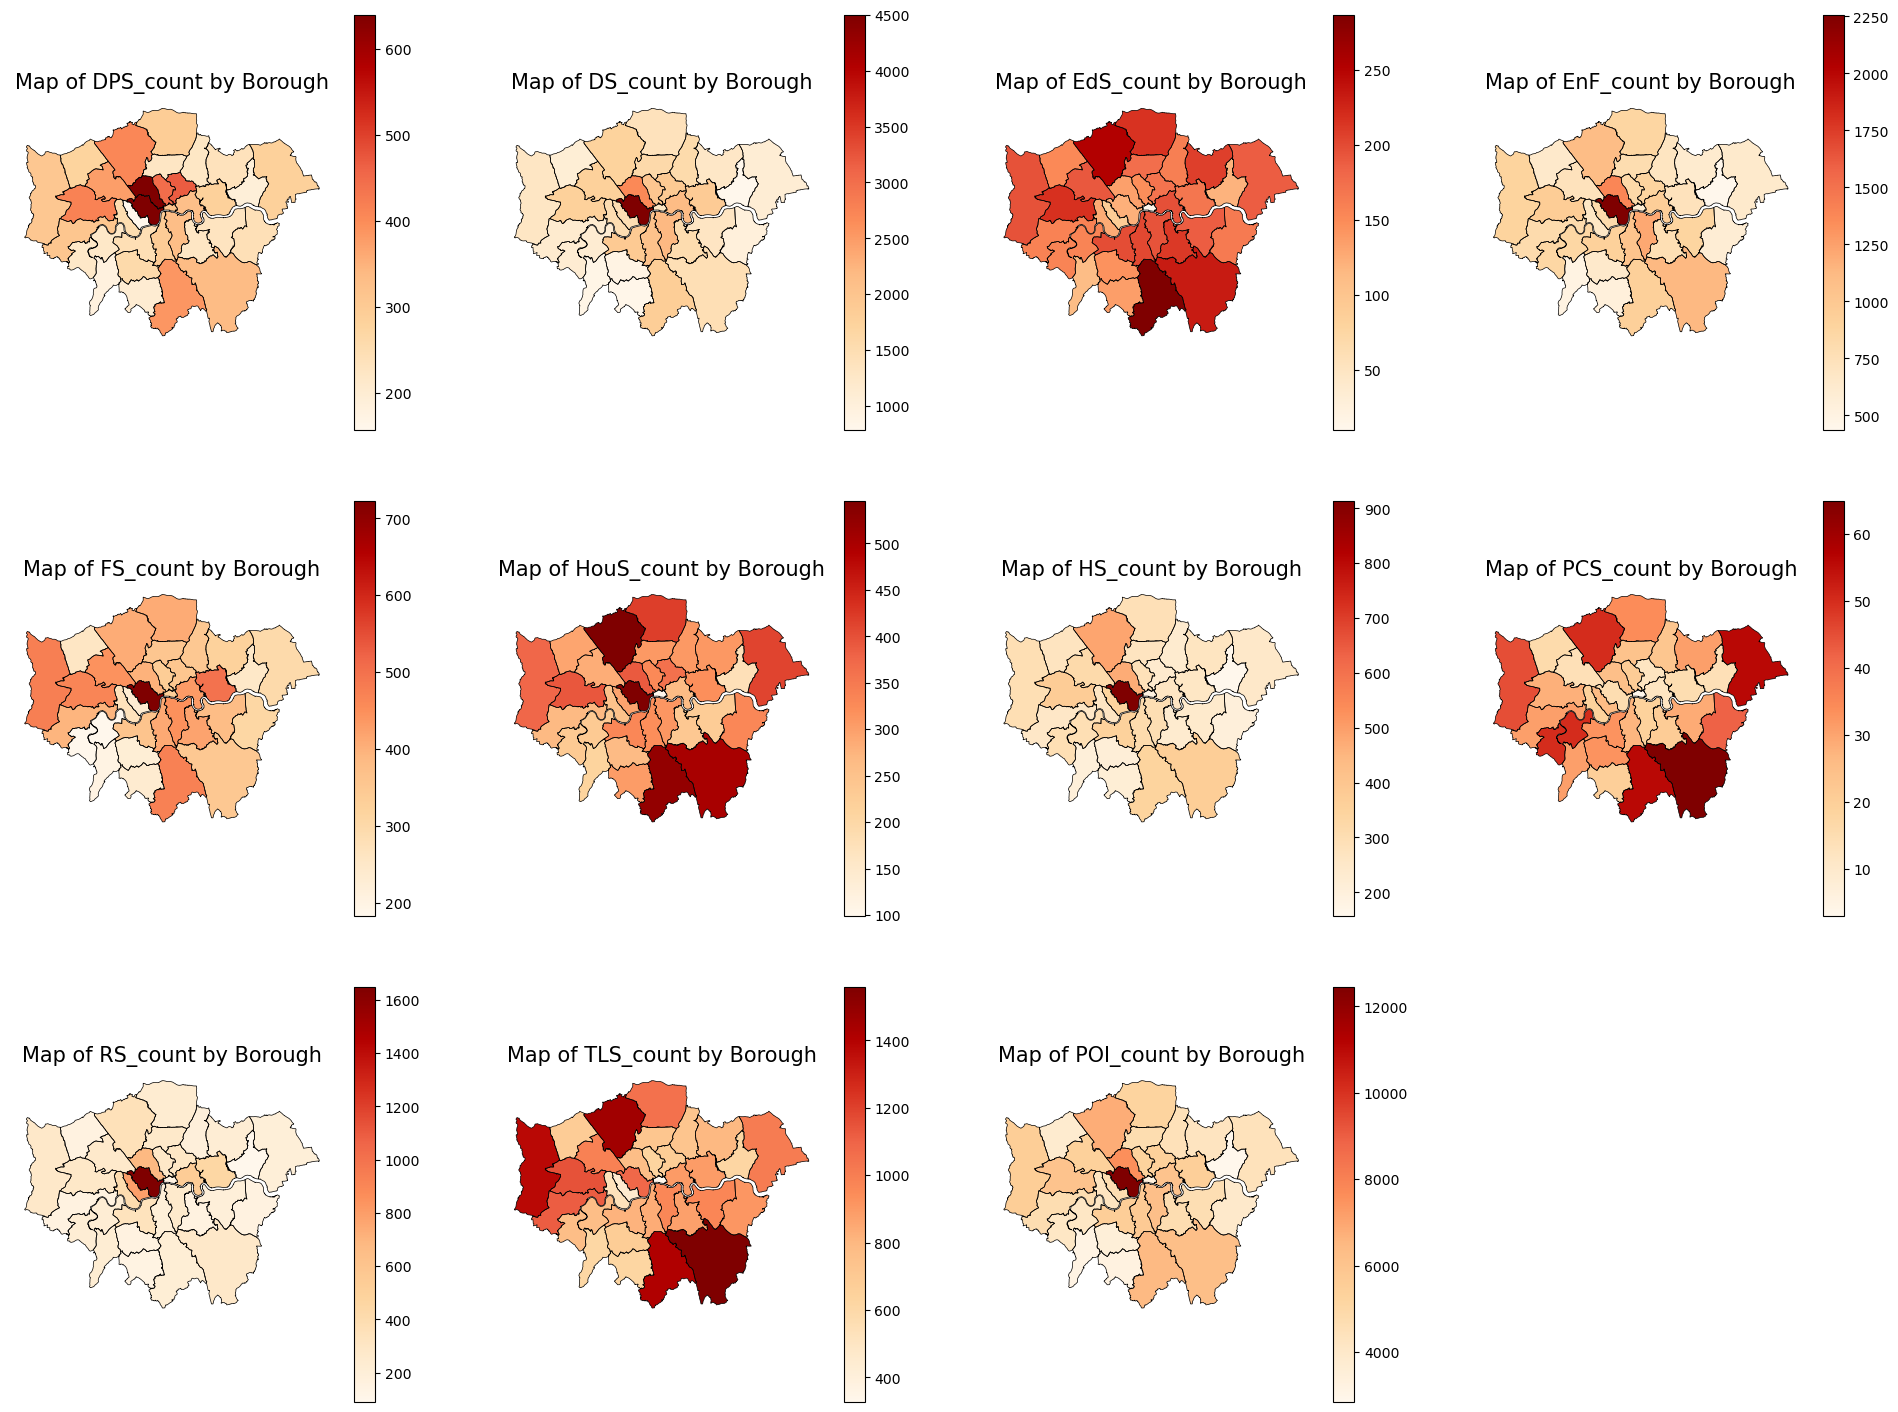

In [19]:
last_eleven_columns = Borough_counts.columns[-11:]

# 创建 3x4 的子图布局，但只使用 11 个子图
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

# 调整布局，以适应标题和图例
fig.tight_layout(pad=3.0)

# 扁平化 axes 数组，便于逐个访问
axes = axes.flatten()

# 为每一列生成一个地图
for i, column in enumerate(last_eleven_columns):
    # 绘制 LSOA_counts 的当前列，使用不同的颜色映射
    Borough_counts.plot(column=column, ax=axes[i], legend=True, cmap='OrRd', edgecolor='none')
    
    # 叠加 Borough 的边界
    Borough.boundary.plot(ax=axes[i], linewidth=0.5, color='black')
    
    # 设置图标题
    axes[i].set_title(f"Map of {column} by Borough", fontsize=15)
    
    # 隐藏坐标轴
    axes[i].set_axis_off()

# 移除多余的子图（仅在最后几张图未占满整个布局时才需要）
for j in range(len(last_eleven_columns), len(axes)):
    fig.delaxes(axes[j])

# 显示整体图形
plt.show()

In [20]:
# 获取最后 11 列的列名
last_eleven_columns = Borough_counts.columns[-11:]

# 初始化一个字典，用于存储结果
results = {}

# 遍历最后 11 列，找到最大值、最小值、众数及其对应行的信息
for column in last_eleven_columns:
    # 找到当前列的最大值和最小值
    max_value = Borough_counts[column].max()
    min_value = Borough_counts[column].min()
    
    
    # 找到最大值和最小值所在的所有行
    max_rows = Borough_counts[Borough_counts[column] == max_value]
    min_rows = Borough_counts[Borough_counts[column] == min_value]
    
    # 获取最大值和最小值所在行的数量
    max_count = max_rows.shape[0]
    min_count = min_rows.shape[0]
    
    # 初始化结果字典
    results[column] = {
        'max_value': max_value,
        'max_count': max_count,
        'min_value': min_value,
        'min_count': min_count,
    }

    # 如果最大值所在行数小于 5，则输出详细信息
    if max_count < 5:
        results[column]['max_info'] = [
            { 'NAME': row['NAME'],} 
            for _, row in max_rows.iterrows()
        ]
    
    # 如果最小值所在行数小于 5，则输出详细信息
    if min_count < 5:
        results[column]['min_info'] = [
             { 'NAME': row['NAME'],} 
            for _, row in min_rows.iterrows()
        ]

# 输出结果
for column, result in results.items():
    print(f"Column: {column}")
    
    # 输出最大值信息
    print(f"  Max Value: {result['max_value']} (Number of rows: {result['max_count']})")
    if result['max_count'] < 5:
        for info in result.get('max_info', []):
            print(f"    (LAD11NM: {info['NAME']})")
    
    # 输出最小值信息
    print(f"  Min Value: {result['min_value']} (Number of rows: {result['min_count']})")
    if result['min_count'] < 5:
        for info in result.get('min_info', []):
            print(f"    (LAD11NM: {info['NAME']})")
    
    print("\n")

Column: DPS_count
  Max Value: 640 (Number of rows: 2)
    (LAD11NM: Westminster)
    (LAD11NM: Camden)
  Min Value: 157 (Number of rows: 1)
    (LAD11NM: Kensington and Chelsea)


Column: DS_count
  Max Value: 4502 (Number of rows: 1)
    (LAD11NM: Westminster)
  Min Value: 787 (Number of rows: 1)
    (LAD11NM: Barking and Dagenham)


Column: EdS_count
  Max Value: 287 (Number of rows: 1)
    (LAD11NM: Croydon)
  Min Value: 10 (Number of rows: 1)
    (LAD11NM: City of London)


Column: EnF_count
  Max Value: 2258 (Number of rows: 1)
    (LAD11NM: Westminster)
  Min Value: 437 (Number of rows: 1)
    (LAD11NM: Barking and Dagenham)


Column: FS_count
  Max Value: 723 (Number of rows: 1)
    (LAD11NM: Westminster)
  Min Value: 183 (Number of rows: 1)
    (LAD11NM: Richmond upon Thames)


Column: HouS_count
  Max Value: 546 (Number of rows: 1)
    (LAD11NM: Barnet)
  Min Value: 99 (Number of rows: 1)
    (LAD11NM: City of London)


Column: HS_count
  Max Value: 914 (Number of rows: 1)
  

In [21]:
Borough_counts

NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER  \
0     Kingston upon Thames  E09000021   3726.117       0.000         F   
1                  Croydon  E09000008   8649.441       0.000         F   
2                  Bromley  E09000006  15013.487       0.000         F   
3                 Hounslow  E09000018   5658.541      60.755         F   
4                   Ealing  E09000009   5554.428       0.000         F   
5                 Havering  E09000016  11445.735     210.763         F   
6               Hillingdon  E09000017  11570.063       0.000         F   
7                   Harrow  E09000015   5046.330       0.000         F   
8                    Brent  E09000005   4323.270       0.000         F   
9                   Barnet  E09000003   8674.837       0.000         F   
10                 Lambeth  E09000022   2724.940      43.927         T   
11               Southwark  E09000028   2991.340     105.139         T   
12                Lewisham  E09000023   3531.706      16.795         T   
13               Greenwich  E09000011   5044.190     310.785         F   
14                  Bexley  E09000004   6428.649     370.619         F   
15                 Enfield  E09000010   8220.025       0.000         F   
16          Waltham Forest  E09000031   3880.793       0.000         F   
17               Redbridge  E09000026   5644.225       2.300         F   
18                  Sutton  E09000029   4384.698       0.000         F   
19    Richmond upon Thames  E09000027   5876.111     135.443         F   
20                  Merton  E09000024   3762.466       0.000         F   
21              Wandsworth  E09000032   3522.022      95.600         T   
22  Hammersmith and Fulham  E09000013   1715.409      75.648         T   
23  Kensington and Chelsea  E09000020   1238.379      25.994         T   
24             Westminster  E09000033   2203.005      54.308         T   
25                  Camden  E09000007   2178.932       0.000         T   
26           Tower Hamlets  E09000030   2157.501     179.707         T   
27               Islington  E09000019   1485.664       0.000         T   
28                 Hackney  E09000012   1904.902       0.000         T   
29                Haringey  E09000014   2959.837       0.000         T   
30                  Newham  E09000025   3857.806     237.637         T   
31    Barking and Dagenham  E09000002   3779.934     169.150         F   
32          City of London  E09000001    314.942      24.546         T   

    SUB_2009  SUB_2006                                           geometry  \
0        NaN       NaN  POLYGON ((516401.600 160201.800, 516407.300 16...   
1        NaN       NaN  POLYGON ((535009.200 159504.700, 535005.500 15...   
2        NaN       NaN  POLYGON ((540373.600 157530.400, 540361.200 15...   
3        NaN       NaN  POLYGON ((521975.800 178100.000, 521967.700 17...   
4        NaN       NaN  POLYGON ((510253.500 182881.600, 510249.900 18...   
5        NaN       NaN  POLYGON ((549893.900 181459.800, 549894.600 18...   
6        NaN       NaN  POLYGON ((510599.800 191689.500, 510615.200 19...   
7        NaN       NaN  POLYGON ((510599.800 191689.500, 510660.000 19...   
8        NaN       NaN  POLYGON ((525201.000 182512.600, 525181.500 18...   
9        NaN       NaN  POLYGON ((524579.900 198355.200, 524594.300 19...   
10       NaN       NaN  POLYGON ((530046.800 177893.400, 530048.400 17...   
11       NaN       NaN  POLYGON ((531335.600 180529.500, 531337.700 18...   
12       NaN       NaN  POLYGON ((536691.000 178958.600, 536691.900 17...   
13       NaN       NaN  MULTIPOLYGON (((537238.700 178137.700, 537242....   
14       NaN       NaN  POLYGON ((547226.200 181299.300, 547320.900 18...   
15       NaN       NaN  POLYGON ((531023.500 200933.600, 531039.900 20...   
16       NaN       NaN  POLYGON ((539923.100 191863.100, 539928.100 19...   
17       NaN       NaN  POLYGON ((543595.500 184832.800, 543577.100 18...   
18       NaN       NaN  POLYGON ((528552.3

In [22]:
Borough_counts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        33 non-null     object  
 1   GSS_CODE    33 non-null     object  
 2   HECTARES    33 non-null     float64 
 3   NONLD_AREA  33 non-null     float64 
 4   ONS_INNER   33 non-null     object  
 5   SUB_2009    0 non-null      float64 
 6   SUB_2006    0 non-null      float64 
 7   geometry    33 non-null     geometry
 8   DPS_count   33 non-null     int64   
 9   DS_count    33 non-null     int64   
 10  EdS_count   33 non-null     int64   
 11  EnF_count   33 non-null     int64   
 12  FS_count    33 non-null     int64   
 13  HouS_count  33 non-null     int64   
 14  HS_count    33 non-null     int64   
 15  PCS_count   33 non-null     int64   
 16  RS_count    33 non-null     int64   
 17  TLS_count   33 non-null     int64   
 18  POI_count   33 non-null     int64   
dtypes:

In [23]:
# 选择 LSOA_counts 的第 16 到 25 列（索引为 15 到 24）
selected_columns_sums = Borough_counts.iloc[:, 8:18].sum()
# 选择 LSOA_counts 的第 16 到 25 列（索引为 15 到 24）
total_sum_columns_16_to_25 = Borough_counts.iloc[:, 8:18].values.sum()

# 输出结果
for column_name, column_sum in selected_columns_sums.items():
    print(f"The sum of {column_name} is: {column_sum}")

print(f"The total sum of service POI within in LSOA_counts is: {total_sum_columns_16_to_25}")

The sum of DPS_count is: 10241
The sum of DS_count is: 53009
The sum of EdS_count is: 5627
The sum of EnF_count is: 28397
The sum of FS_count is: 12017
The sum of HouS_count is: 10749
The sum of HS_count is: 10022
The sum of PCS_count is: 940
The sum of RS_count is: 10545
The sum of TLS_count is: 29019
The total sum of service POI within in LSOA_counts is: 170566


### 3.1.3 Open Road

In [24]:
# RoadNetworkurl=https://github.com/ZuoLiya/Liya-Zuo-Dissertation/blob/64bce7cff755da44d703cc866e970df6c9196297/3.1%20Data/London%20Road%20Network.zip

### 3.1.4 Population

#### 3.1.4.1 2023-2024 Population

In [25]:
Population_Rate = 1.04

#### 3.1.4.2 Borough Population

In [26]:
Borough2023 = pd.read_csv('https://github.com/ZuoLiya/Liya-Zuo-Dissertation/raw/01c0267b29f95693db1bdd4ca5890555dfb4897f/3.1%20Data/Population/Borough%202023.csv', sep=',')
Borough2023

Borough Code            Borough Name   2023 
0     E09000007                  Camden  220903
1     E09000001          City of London   13462
2     E09000012                 Hackney  263282
3     E09000013  Hammersmith and Fulham  186176
4     E09000014                Haringey  262895
5     E09000019               Islington  220584
6     E09000020  Kensington and Chelsea  147460
7     E09000022                 Lambeth  315706
8     E09000023                Lewisham  298708
9     E09000025                  Newham  362552
10    E09000028               Southwark  315519
11    E09000030           Tower Hamlets  328626
12    E09000032              Wandsworth  331456
13    E09000033             Westminster  211508
14    E09000002    Barking and Dagenham  222308
15    E09000003                  Barnet  395007
16    E09000004                  Bexley  250853
17    E09000005                   Brent  344521
18    E09000006                 Bromley  331162
19    E09000008                 Croydon  397741
20    E09000009                  Ealing  375340
21    E09000010                 Enfield  327429
22    E09000011               Greenwich  294113
23    E09000015                  Harrow  263448
24    E09000016                Havering  268145
25    E09000017              Hillingdon  319018
26    E09000018                Hounslow  295706
27    E09000021    Kingston upon Thames  170454
28    E09000024                  Merton  215219
29    E09000026               Redbridge  313392
30    E09000027    Richmond upon Thames  195513
31    E09000029                  Sutton  211123
32    E09000031          Waltham Forest  275980

In [27]:
Borough2023.rename(columns=lambda x: x.strip(), inplace=True)
Borough2024 = pd.merge(Borough, Borough2023[['Borough Code', '2023']], left_on='GSS_CODE', right_on='Borough Code', how='left')
Borough2024['2024'] = (Borough2024['2023'] * (1 + Population_Rate/100)).round().astype(float)

Borough2024.drop(columns=['NONLD_AREA', 'ONS_INNER', 'SUB_2009', 'SUB_2006', 'Borough Code'], inplace=True)
Borough2024

NAME   GSS_CODE   HECTARES  \
0     Kingston upon Thames  E09000021   3726.117   
1                  Croydon  E09000008   8649.441   
2                  Bromley  E09000006  15013.487   
3                 Hounslow  E09000018   5658.541   
4                   Ealing  E09000009   5554.428   
5                 Havering  E09000016  11445.735   
6               Hillingdon  E09000017  11570.063   
7                   Harrow  E09000015   5046.330   
8                    Brent  E09000005   4323.270   
9                   Barnet  E09000003   8674.837   
10                 Lambeth  E09000022   2724.940   
11               Southwark  E09000028   2991.340   
12                Lewisham  E09000023   3531.706   
13               Greenwich  E09000011   5044.190   
14                  Bexley  E09000004   6428.649   
15                 Enfield  E09000010   8220.025   
16          Waltham Forest  E09000031   3880.793   
17               Redbridge  E09000026   5644.225   
18                  Sutton  E09000029   4384.698   
19    Richmond upon Thames  E09000027   5876.111   
20                  Merton  E09000024   3762.466   
21              Wandsworth  E09000032   3522.022   
22  Hammersmith and Fulham  E09000013   1715.409   
23  Kensington and Chelsea  E09000020   1238.379   
24             Westminster  E09000033   2203.005   
25                  Camden  E09000007   2178.932   
26           Tower Hamlets  E09000030   2157.501   
27               Islington  E09000019   1485.664   
28                 Hackney  E09000012   1904.902   
29                Haringey  E09000014   2959.837   
30                  Newham  E09000025   3857.806   
31    Barking and Dagenham  E09000002   3779.934   
32          City of London  E09000001    314.942   

                                             geometry    2023      2024  
0   POLYGON ((516401.600 160201.800, 516407.300 16...  170454  172227.0  
1   POLYGON ((535009.200 159504.700, 535005.500 15...  397741  401878.0  
2   POLYGON ((540373.600 157530.400, 540361.200 15...  331162  334606.0  
3   POLYGON ((521975.800 178100.000, 521967.700 17...  295706  298781.0  
4   POLYGON ((510253.500 182881.600, 510249.900 18...  375340  379244.0  
5   POLYGON ((549893.900 181459.800, 549894.600 18...  268145  270934.0  
6   POLYGON ((510599.800 191689.500, 510615.200 19...  319018  322336.0  
7   POLYGON ((510599.800 191689.500, 510660.000 19...  263448  266188.0  
8   POLYGON ((525201.000 182512.600, 525181.500 18...  344521  348104.0  
9   POLYGON ((524579.900 198355.200, 524594.300 19...  395007  399115.0  
10  POLYGON ((530046.800 177893.400, 530048.400 17...  315706  318989.0  
11  POLYGON ((531335.600 180529.500, 531337.700 18...  315519  318800.0  
12  POLYGON ((536691.000 178958.600, 536691.900 17...  298708  301815.0  
13  MULTIPOLYGON (((537238.700 178137.700, 537242....  294113  297172.0  
14  POLYGON ((547226.200 181299.300, 547320.900 18...  250853  253462.0  
15  POLYGON ((531023.500 200933.600, 531039.900 20...  327429  330834.0  
16  POLYGON ((539923.100 191863.100, 539928.100 19...  275980  278850.0  
17  POLYGON ((543595.500 184832.800, 543577.100 18...  313392  316651.0  
18  POLYGON ((528552.300 159658.100, 528399.700 15...  211123  213319.0  
19  POLYGON ((516677.500 175383.800, 516678.600 17...  195513  197546.0  
20  POLYGON ((529906.200 167417.300, 529902.200 16...  215219  217457.0  
21  POLYGON ((523489.600 176224.800, 523500.600 17...  331456  334903.0  
22  POLYGON ((521975.800 178100.000, 521973.000 17...  186176  188112.0  
23  POLYGON ((526219.700 176948.000, 526208.800 17...  147460  148994.0  
24  POLYGON ((528549.500 177903.800, 528542.600 17...  211508  213708.0  
25  POLYGON ((528840.200 187217.800, 528834.600 18...  220903  223200.0  
26  POLYGON ((533387.600 180516.400, 533389.800 18...  328626  332044.0  
27  POLYGON ((529153.600 185861.400, 529144.800 18...  220584  222878.0  
28  POLYGON ((531928.400 187801.500, 531935.700 18...  263282  266020.0  
29  POLYGON ((531928.400 187801.5

#### 3.1.4.3 LSOA Population

In [28]:
Link1121 = pd.read_csv("https://github.com/ZuoLiya/Liya-Zuo-Dissertation/raw/6c731c5f7450028f072ba1e90a6f9ef4a9514917/3.1%20Data/Population/1121.csv")
Link1121

LSOA11CD             LSOA11NM   LSOA21CD             LSOA21NM  \
0     E01000001  City of London 001A  E01000001  City of London 001A   
1     E01000002  City of London 001B  E01000002  City of London 001B   
2     E01000003  City of London 001C  E01000003  City of London 001C   
3     E01000005  City of London 001E  E01000005  City of London 001E   
4     E01032739  City of London 001F  E01032739  City of London 001F   
...         ...                  ...        ...                  ...   
5011  E01004712     Westminster 008C  E01004712     Westminster 008C   
5012  E01004727     Westminster 008D  E01004727     Westminster 008D   
5013  E01004670     Westminster 009A  E01004670     Westminster 009A   
5014  E01004702     Westminster 009E  E01004702     Westminster 009E   
5015  E01033598     Westminster 009F  E01033598     Westminster 009F   

        LAD22CD         LAD22NM  
0     E09000001  City of London  
1     E09000001  City of London  
2     E09000001  City of London  
3     E09000001  City of London  
4     E09000001  City of London  
...         ...             ...  
5011  E09000033     Westminster  
5012  E09000033     Westminster  
5013  E09000033     Westminster  
5014  E09000033     Westminster  
5015  E09000033     Westminster  

[5016 rows x 6 columns]

In [29]:
LSOA2022 = pd.read_csv('https://github.com/ZuoLiya/Liya-Zuo-Dissertation/raw/6c731c5f7450028f072ba1e90a6f9ef4a9514917/3.1%20Data/Population/LSOA%202022.csv')
LSOA2022

LAD 2021 Code   LAD 2021 Name LSOA 2021 Code       LSOA 2021 Name  2022
0        E09000001  City of London      E01000001  City of London 001A  1721
1        E09000001  City of London      E01000002  City of London 001B  1608
2        E09000001  City of London      E01000003  City of London 001C  1826
3        E09000001  City of London      E01000005  City of London 001E  1605
4        E09000001  City of London      E01032739  City of London 001F  2376
...            ...             ...            ...                  ...   ...
4989     E09000033     Westminster      E01035718     Westminster 019G  2793
4990     E09000033     Westminster      E01035719     Westminster 021F  1319
4991     E09000033     Westminster      E01035720     Westminster 021G  1279
4992     E09000033     Westminster      E01035721     Westminster 023H  2245
4993     E09000033     Westminster      E01035722     Westminster 024G  2147

[4994 rows x 5 columns]

In [30]:
total_by_lad = LSOA2022.groupby('LAD 2021 Code')['2022'].sum().reset_index()
total_by_lad = total_by_lad.rename(columns={'2022': 'total_2022'})

# 将计算的总和合并回 LSOA2022
LSOA2022 = pd.merge(LSOA2022, total_by_lad, on='LAD 2021 Code', how='left')

# 计算 'radio' 列，值为该行在列 '2022' 的值除以所对应 'total_2022' 的比值
LSOA2022['ratio'] = LSOA2022['2022'] / LSOA2022['total_2022'].round().astype(float)
LSOA2022 = LSOA2022.drop(columns=['total_2022'])
LSOA2022

LAD 2021 Code   LAD 2021 Name LSOA 2021 Code       LSOA 2021 Name  2022  \
0        E09000001  City of London      E01000001  City of London 001A  1721   
1        E09000001  City of London      E01000002  City of London 001B  1608   
2        E09000001  City of London      E01000003  City of London 001C  1826   
3        E09000001  City of London      E01000005  City of London 001E  1605   
4        E09000001  City of London      E01032739  City of London 001F  2376   
...            ...             ...            ...                  ...   ...   
4989     E09000033     Westminster      E01035718     Westminster 019G  2793   
4990     E09000033     Westminster      E01035719     Westminster 021F  1319   
4991     E09000033     Westminster      E01035720     Westminster 021G  1279   
4992     E09000033     Westminster      E01035721     Westminster 023H  2245   
4993     E09000033     Westminster      E01035722     Westminster 024G  2147   

         ratio  
0     0.158661  
1     0.148244  
2     0.168341  
3     0.147967  
4     0.219047  
...        ...  
4989  0.013214  
4990  0.006240  
4991  0.006051  
4992  0.010621  
4993  0.010158  

[4994 rows x 6 columns]

In [31]:
LSOA2024 = pd.merge(LSOA2022, Borough2024[['GSS_CODE', '2024']], left_on='LAD 2021 Code', right_on='GSS_CODE', how='left')
# 计算新的 '2024' 列，值为合并后 Borough2024 中 '2024' 列与 LSOA2022 中 'ratio' 列的乘积
LSOA2024['2024'] = LSOA2024['2024'] * LSOA2024['ratio'].astype(float)
LSOA2024

LAD 2021 Code   LAD 2021 Name LSOA 2021 Code       LSOA 2021 Name  2022  \
0        E09000001  City of London      E01000001  City of London 001A  1721   
1        E09000001  City of London      E01000002  City of London 001B  1608   
2        E09000001  City of London      E01000003  City of London 001C  1826   
3        E09000001  City of London      E01000005  City of London 001E  1605   
4        E09000001  City of London      E01032739  City of London 001F  2376   
...            ...             ...            ...                  ...   ...   
4989     E09000033     Westminster      E01035718     Westminster 019G  2793   
4990     E09000033     Westminster      E01035719     Westminster 021F  1319   
4991     E09000033     Westminster      E01035720     Westminster 021G  1279   
4992     E09000033     Westminster      E01035721     Westminster 023H  2245   
4993     E09000033     Westminster      E01035722     Westminster 024G  2147   

         ratio   GSS_CODE         2024  
0     0.158661  E09000001  2158.112105  
1     0.148244  E09000001  2016.411542  
2     0.168341  E09000001  2289.780769  
3     0.147967  E09000001  2012.649581  
4     0.219047  E09000001  2979.473772  
...        ...        ...          ...  
4989  0.013214  E09000033  2823.960656  
4990  0.006240  E09000033  1333.621233  
4991  0.006051  E09000033  1293.177830  
4992  0.010621  E09000033  2269.886027  
4993  0.010158  E09000033  2170.799688  

[4994 rows x 8 columns]

In [32]:
merged_df = pd.merge(LSOA2024, Link1121[['LSOA21CD', 'LSOA11NM']], left_on='LSOA 2021 Code', right_on='LSOA21CD', how='left')

# 根据 'LSOA11NM' 进行分组，并计算每个组中 '2024' 列的和
grouped_df = merged_df.groupby('LSOA11NM')['2024'].sum().reset_index()

# 创建新的 DataFrame LSOA202411，包含 'LSOA11NM' 和对应的 '2024' 列的和
LSOA202411 = grouped_df.rename(columns={'2024': 'LSOA2024'})
LSOA202411

LSOA11NM     LSOA2024
0     Barking and Dagenham 001A  2139.072784
1     Barking and Dagenham 001B  1846.035129
2     Barking and Dagenham 001C  1980.812030
3     Barking and Dagenham 001D  2594.455344
4     Barking and Dagenham 002A  1853.182388
...                         ...          ...
4830           Westminster 024B  1708.733802
4831           Westminster 024C  1268.911788
4832           Westminster 024D  2170.799688
4833           Westminster 024E  2170.799688
4834           Westminster 024F  1326.543638

[4835 rows x 2 columns]

In [33]:
LSOA2024in11 = LSOA.merge(LSOA202411, on='LSOA11NM', how='left')
LSOA2024in11 = LSOA2024in11.drop(columns=['USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ'])
LSOA2024in11['LSOA2024'] = LSOA2024in11['LSOA2024'].astype(int)
LSOA2024in11['Area'] = LSOA2024in11['geometry'].area / 10**6
LSOA2024in11['2024POPDEN'] = LSOA2024in11['LSOA2024'] / LSOA2024in11['Area']
LSOA2024in11

LSOA11CD                   LSOA11NM   MSOA11CD  \
0     E01000001        City of London 001A  E02000001   
1     E01000002        City of London 001B  E02000001   
2     E01000003        City of London 001C  E02000001   
3     E01000005        City of London 001E  E02000001   
4     E01000006  Barking and Dagenham 016A  E02000017   
...         ...                        ...        ...   
4830  E01033742             Greenwich 007F  E02000319   
4831  E01033743             Greenwich 002H  E02000314   
4832  E01033744             Greenwich 007G  E02000319   
4833  E01033745             Greenwich 002I  E02000314   
4834  E01033746             Greenwich 038E  E02006931   

                      MSOA11NM    LAD11CD               LAD11NM    RGN11CD  \
0           City of London 001  E09000001        City of London  E12000007   
1           City of London 001  E09000001        City of London  E12000007   
2           City of London 001  E09000001        City of London  E12000007   
3           City of London 001  E09000001        City of London  E12000007   
4     Barking and Dagenham 016  E09000002  Barking and Dagenham  E12000007   
...                        ...        ...                   ...        ...   
4830             Greenwich 007  E09000011             Greenwich  E12000007   
4831             Greenwich 002  E09000011             Greenwich  E12000007   
4832             Greenwich 007  E09000011             Greenwich  E12000007   
4833             Greenwich 002  E09000011             Greenwich  E12000007   
4834             Greenwich 038  E09000011             Greenwich  E12000007   

     RGN11NM                                           geometry  LSOA2024  \
0     London  POLYGON ((532105.092 182011.230, 532162.491 18...      2158   
1     London  POLYGON ((532746.813 181786.891, 532671.688 18...      2016   
2     London  POLYGON ((532135.145 182198.119, 532158.250 18...      2289   
3     London  POLYGON ((533807.946 180767.770, 533649.063 18...      2012   
4     London  POLYGON ((545122.049 184314.931, 545271.917 18...      1871   
...      ...                                                ...       ...   
4830  London  POLYGON ((544642.680 179824.674, 544766.313 17...      1387   
4831  London  POLYGON ((546579.195 181097.813, 546687.036 18...      1973   
4832  London  POLYGON ((544536.486 179447.115, 544602.630 17...      1802   
4833  London  POLYGON ((546415.745 180152.270, 546320.715 18...      1709   
4834  London  POLYGON ((538140.000 177313.000, 538129.177 17...      1543   

          Area    2024POPDEN  
0     0.133321  16186.525314  
1     0.226191   8912.810705  
2     0.057303  39945.575922  
3     0.190739  10548.459027  
4     0.144196  12975.408382  
...        ...           ...  
4830  0.123309  11248.148255  
4831  1.004853   1963.471103  
4832  0.152262  11834.864110  
4833  0.558478   3060.104266  
4834  0.128977  11963.402409  

[4835 rows x 12 columns]

In [34]:
LSOA2024in11 = LSOA.merge(LSOA202411, on='LSOA11NM', how='left')
LSOA2024in11 = LSOA2024in11.drop(columns=['USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ'])
LSOA2024in11['LSOA2024'] = LSOA2024in11['LSOA2024'].astype(int)
LSOA2024in11['Area'] = LSOA2024in11['geometry'].area / 10**6
LSOA2024in11['2024POPDEN'] = LSOA2024in11['LSOA2024'] / LSOA2024in11['Area']
LSOA2024in11

LSOA11CD                   LSOA11NM   MSOA11CD  \
0     E01000001        City of London 001A  E02000001   
1     E01000002        City of London 001B  E02000001   
2     E01000003        City of London 001C  E02000001   
3     E01000005        City of London 001E  E02000001   
4     E01000006  Barking and Dagenham 016A  E02000017   
...         ...                        ...        ...   
4830  E01033742             Greenwich 007F  E02000319   
4831  E01033743             Greenwich 002H  E02000314   
4832  E01033744             Greenwich 007G  E02000319   
4833  E01033745             Greenwich 002I  E02000314   
4834  E01033746             Greenwich 038E  E02006931   

                      MSOA11NM    LAD11CD               LAD11NM    RGN11CD  \
0           City of London 001  E09000001        City of London  E12000007   
1           City of London 001  E09000001        City of London  E12000007   
2           City of London 001  E09000001        City of London  E12000007   
3           City of London 001  E09000001        City of London  E12000007   
4     Barking and Dagenham 016  E09000002  Barking and Dagenham  E12000007   
...                        ...        ...                   ...        ...   
4830             Greenwich 007  E09000011             Greenwich  E12000007   
4831             Greenwich 002  E09000011             Greenwich  E12000007   
4832             Greenwich 007  E09000011             Greenwich  E12000007   
4833             Greenwich 002  E09000011             Greenwich  E12000007   
4834             Greenwich 038  E09000011             Greenwich  E12000007   

     RGN11NM                                           geometry  LSOA2024  \
0     London  POLYGON ((532105.092 182011.230, 532162.491 18...      2158   
1     London  POLYGON ((532746.813 181786.891, 532671.688 18...      2016   
2     London  POLYGON ((532135.145 182198.119, 532158.250 18...      2289   
3     London  POLYGON ((533807.946 180767.770, 533649.063 18...      2012   
4     London  POLYGON ((545122.049 184314.931, 545271.917 18...      1871   
...      ...                                                ...       ...   
4830  London  POLYGON ((544642.680 179824.674, 544766.313 17...      1387   
4831  London  POLYGON ((546579.195 181097.813, 546687.036 18...      1973   
4832  London  POLYGON ((544536.486 179447.115, 544602.630 17...      1802   
4833  London  POLYGON ((546415.745 180152.270, 546320.715 18...      1709   
4834  London  POLYGON ((538140.000 177313.000, 538129.177 17...      1543   

          Area    2024POPDEN  
0     0.133321  16186.525314  
1     0.226191   8912.810705  
2     0.057303  39945.575922  
3     0.190739  10548.459027  
4     0.144196  12975.408382  
...        ...           ...  
4830  0.123309  11248.148255  
4831  1.004853   1963.471103  
4832  0.152262  11834.864110  
4833  0.558478   3060.104266  
4834  0.128977  11963.402409  

[4835 rows x 12 columns]

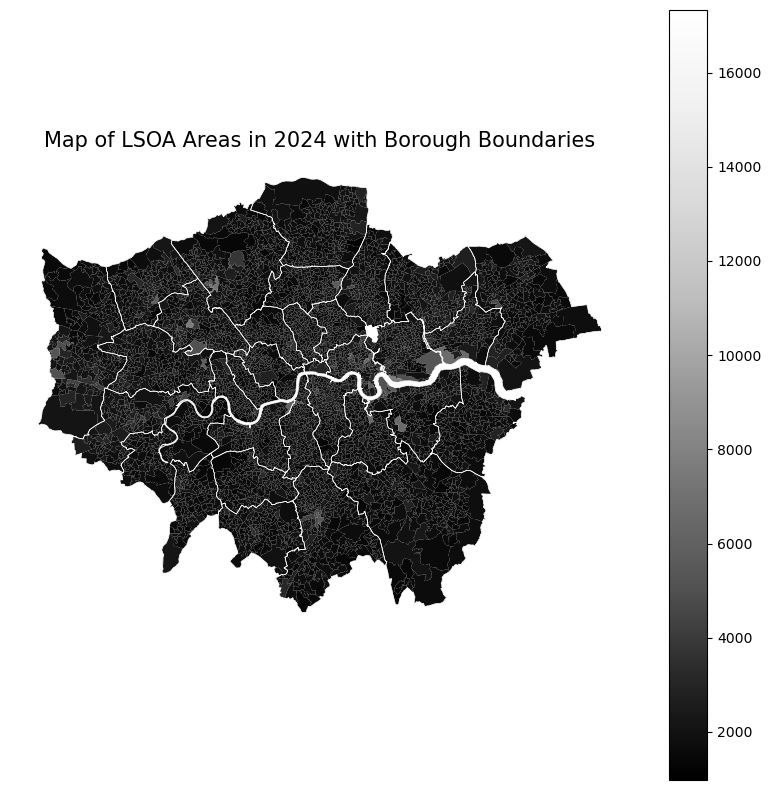

In [35]:
# 绘制地图，使用从灰到黑的色带，不描边
fig, ax = plt.subplots(figsize=(10, 10))  # 设置图形的大小
LSOA2024in11.plot(column='LSOA2024', ax=ax, legend=True, cmap='Greys_r', edgecolor='none')

# 叠加 Borough 的几何图形线框
Borough.boundary.plot(ax=ax, linewidth=0.5, color='White')

# 设置图标题和其他属性
ax.set_title("Map of LSOA Areas in 2024 with Borough Boundaries", fontsize=15)
ax.set_axis_off()  # 隐藏坐标轴

# 显示图形
plt.show()

# 4 Results
Following the calculation of the 1km buffer and pedestrian catchment for each POI in ArcMap, the results were exported as separate shapefiles and imported into the current process. These shapefiles include the buffer and pedestrian catchment areas for each potential POI serving London, as well as the merged buffer and pedestrian catchment for all service POIs across London.

Download measured geodata:
- [1km Pedestrian Walkable Catchment](https://liveuclac-my.sharepoint.com/:u:/r/personal/ucfnlzu_ucl_ac_uk/Documents/Dissertation%20Data/1km%20Pedestrian%20Walkable%20Catchment.zip?csf=1&web=1&e=mKEcqP)
- [Merged 1km Buffer](https://liveuclac-my.sharepoint.com/:u:/r/personal/ucfnlzu_ucl_ac_uk/Documents/Dissertation%20Data/Merged%201km%20Buffer.zip?csf=1&web=1&e=laPxYm)

## 4.1 Coverage, Walkability, Cluster, Hierachical Tree

### 4.1.1 POIs Count of Serving London

In [36]:
def extract_and_load_shp(zip_path, output_dir):
    # 解压缩外部 ZIP 文件
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

    # 获取解压后文件夹中所有 ZIP 文件的路径
    zip_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.zip')]

    # 读取每个 ZIP 文件中的 SHP 文件并导出为 GeoDataFrame
    gdfs = {}
    temp_dir = "temp_shp"  # 临时文件夹名称
    for zip_file in zip_files:
        with zipfile.ZipFile(zip_file, 'r') as shp_zip_ref:
            shp_zip_ref.extractall(temp_dir)  # 解压到临时文件夹
            # 查找并读取 SHP 文件
            shp_files = [os.path.join(temp_dir, f) for f in os.listdir(temp_dir) if f.endswith('.shp')]
            for shp_file in shp_files:
                gdf_name = os.path.splitext(os.path.basename(shp_file))[0]  # 使用 SHP 文件名作为 gdf 名称
                gdfs[gdf_name] = gpd.read_file(shp_file)
            # 清理临时文件夹
            shutil.rmtree(temp_dir)
    
    # 返回所有 GeoDataFrame 的字典
    return gdfs

In [37]:
# 处理 Catchment ZIP 文件
catchment_zip_path = "1km Pedestrian Walkable Catchment.zip"
Catchmentgdfs = extract_and_load_shp(catchment_zip_path, "catchment_unzipped_files")

# 打印 Catchment GeoDataFrame 信息
for name, gdf in Catchmentgdfs.items():
    print(f"{name} Catchment GeoDataFrame:")
    print(f"{len(gdf)} {name}")  # 输出行数
    # gdf.info()
    print("\n")

DPS_ServingWithinL Catchment GeoDataFrame:
10419 DPS_ServingWithinL


TLS_ServingWithinL Catchment GeoDataFrame:
30244 TLS_ServingWithinL


DS_ServingWithinL Catchment GeoDataFrame:
53525 DS_ServingWithinL


EdS_ServingWithinL Catchment GeoDataFrame:
5717 EdS_ServingWithinL


EnF_ServingWithinL Catchment GeoDataFrame:
29043 EnF_ServingWithinL


FS_ServingWithinL Catchment GeoDataFrame:
12173 FS_ServingWithinL


HouS_ServingWithinL Catchment GeoDataFrame:
10944 HouS_ServingWithinL


HS_ServingWithinL Catchment GeoDataFrame:
10144 HS_ServingWithinL


PCS_ServingWithinL Catchment GeoDataFrame:
966 PCS_ServingWithinL


RS_ServingWithinL Catchment GeoDataFrame:
10625 RS_ServingWithinL




In [38]:
for name, gdf in Catchmentgdfs.items():
    print(f"{name} Catchment GeoDataFrame:")
    gdf.info()
    print("\n")

DPS_ServingWithinL Catchment GeoDataFrame:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10419 entries, 0 to 10418
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ObjectID    10419 non-null  int64   
 1   FacilityID  10419 non-null  int64   
 2   Name        10419 non-null  object  
 3   FromBreak   10419 non-null  float64 
 4   ToBreak     10419 non-null  float64 
 5   geometry    10419 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(1)
memory usage: 488.5+ KB


TLS_ServingWithinL Catchment GeoDataFrame:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 30244 entries, 0 to 30243
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ObjectID    30244 non-null  int64   
 1   FacilityID  30244 non-null  int64   
 2   Name        30244 non-null  object  
 3   FromBreak   30244 non-null  float64 
 4   ToBreak   

### 4.1.2 1km Service  Buffer

In [39]:
# 本地 ZIP 文件路径
Buffer_zip_path = "Merged 1km Buffer.zip"
Buffer_output_dir = "unzipped_files"

# 解压 ZIP 文件
with zipfile.ZipFile(Buffer_zip_path, 'r') as zip_ref:
    zip_ref.extractall(Buffer_output_dir)

# 查找解压后的 SHP 文件路径
Buffer_shp_files = [os.path.join(Buffer_output_dir, f) for f in os.listdir(Buffer_output_dir) if f.endswith('.shp')]

# 读取每个 SHP 文件为 GeoDataFrame，并计算面积
gdfs = {}
for shp_file in Buffer_shp_files:
    gdf_name = os.path.splitext(os.path.basename(shp_file))[0]  # 使用 SHP 文件名作为 gdf 名称
    gdfs[gdf_name] = gpd.read_file(shp_file)

    # 计算面积，单位为平方千米，并存储在新列 'Area' 中
    gdfs[gdf_name]['Area'] = gdfs[gdf_name].geometry.area / 1e6  # 如果 CRS 使用的是米为单位
    
    print(f"{gdf_name} GeoDataFrame loaded with {len(gdfs[gdf_name])} records.")
    # print(gdfs[gdf_name][['geometry', 'Area']])  # 输出所有记录的几何和面积信息

    for idx, area in enumerate(gdfs[gdf_name]['Area']):
        print(f"The total area of {gdf_name} is {area:.6f} square kilometers")

# # 打印读取的 GeoDataFrame 信息
# for name, gdf in gdfs.items():
#     # print(f"{name} GeoDataFrame:")
#     # gdf.info()
#     print("\n")

DPS_MergedBuffer GeoDataFrame loaded with 1 records.
The total area of DPS_MergedBuffer is 1720.443046 square kilometers
DS_MergedServed GeoDataFrame loaded with 1 records.
The total area of DS_MergedServed is 1380.845719 square kilometers
EdS_MergedBuffer GeoDataFrame loaded with 1 records.
The total area of EdS_MergedBuffer is 1643.429989 square kilometers
EnF_MergedBuffer GeoDataFrame loaded with 1 records.
The total area of EnF_MergedBuffer is 1917.840223 square kilometers
FS_MergedBuffer GeoDataFrame loaded with 1 records.
The total area of FS_MergedBuffer is 1596.383397 square kilometers
HouS_MergedBuffer GeoDataFrame loaded with 1 records.
The total area of HouS_MergedBuffer is 1756.396125 square kilometers
HS_MergedBuffer GeoDataFrame loaded with 1 records.
The total area of HS_MergedBuffer is 1575.435974 square kilometers
PCS_MergedBuffer GeoDataFrame loaded with 1 records.
The total area of PCS_MergedBuffer is 1291.363697 square kilometers
RS_MergedBuffer GeoDataFrame loaded 

### 4.1.3 Service Area Cluster

In [40]:
import geopandas as gpd
from shapely.ops import unary_union, split

# 创建一个字典来保存所有合并后的 GeoDataFrame
MergedCatchmentgdfs = {}
total_areas = {}  # 创建一个字典来保存每个 gdf 的总面积
coverage_ratios = {}  # 创建一个字典来保存每个 gdf 的 coverage

# 定义总面积常数
total_area_constant = 1573.400741

# 循环遍历每个 GeoDataFrame
for name, gdf in Catchmentgdfs.items():
    print(f"Processing {name} GeoDataFrame...")

    # 创建一个空的列表来保存最终的合并结果
    merged_polygons = []
    unmerged_polygons = list(gdf.geometry)

    # 迭代合并过程
    while unmerged_polygons:
        polygon = unmerged_polygons.pop(0)
        merge_occurred = False

        for i in range(len(unmerged_polygons)):
            if polygon.intersects(unmerged_polygons[i]) or polygon.touches(unmerged_polygons[i]):
                # 如果当前多边形与待处理列表中的多边形相交或接触，则合并
                polygon = unary_union([polygon, unmerged_polygons.pop(i)])
                merge_occurred = True
                break

        if merge_occurred:
            # 如果发生了合并，将合并后的多边形放回待处理列表继续处理
            unmerged_polygons.append(polygon)
        else:
            # 如果没有发生合并，则将多边形添加到合并结果列表中
            merged_polygons.append(polygon)

    # 拆分 MULTIPOLYGON 为单独的 POLYGON
    split_polygons = []
    for geom in merged_polygons:
        if isinstance(geom, MultiPolygon):
            split_polygons.extend(list(geom.geoms))  # 遍历 MultiPolygon 中的 Polygon
        else:
            split_polygons.append(geom)

    # 创建新的 GeoDataFrame 保存拆分后的多边形，并命名为 _ClusteredServed
    new_name = name.replace("ServingWithinL", "ClusteredServed")
    merged_gdf = gpd.GeoDataFrame(geometry=split_polygons, crs=gdf.crs)

    # 计算面积，单位为平方千米
    merged_gdf['area_km2'] = merged_gdf['geometry'].area / 1e6

    # 过滤掉面积小于等于 0.000002 平方千米的行
    filtered_gdf = merged_gdf[merged_gdf['area_km2'] > 0.000002]

    # 计算每个合并后的 gdf 的总面积，单位为平方千米
    total_area = filtered_gdf['area_km2'].sum()

    # 计算 coverage
    coverage = total_area / total_area_constant

    # 将总面积和 coverage 保存到字典中
    total_areas[new_name] = total_area
    coverage_ratios[new_name] = coverage

    # 将过滤后的 GeoDataFrame 保存到字典中
    MergedCatchmentgdfs[new_name] = filtered_gdf

    # 打印合并后的结果、总面积和 coverage
    print(f"{new_name} GeoDataFrame after merging, splitting, and filtering:")
    print(f"Total area: {total_area:.6f} square kilometers")
    print(f"Coverage: {coverage:.6%}")
    print(f"Cluster number: {len(filtered_gdf)} {new_name}")
    # print(filtered_gdf.head())  # 打印前几行以检查结果
    print("\n")

    # 如果需要，可以保存合并后的 GeoDataFrame 到文件
    # filtered_gdf.to_file(f"10-5 Result/{new_name}.shp")

# 最终的 MergedCatchmentgdfs 字典包含了所有过滤后的 GeoDataFrame
# total_areas 字典包含了每个 gdf 的总面积
# coverage_ratios 字典包含了每个 gdf 的 coverage

Processing DPS_ServingWithinL GeoDataFrame...
DPS_ClusteredServed GeoDataFrame after merging, splitting, and filtering:
Total area: 1202.290839 square kilometers
Coverage: 76.413517%
Cluster number: 45 DPS_ClusteredServed


Processing TLS_ServingWithinL GeoDataFrame...
TLS_ClusteredServed GeoDataFrame after merging, splitting, and filtering:
Total area: 1385.172768 square kilometers
Coverage: 88.036870%
Cluster number: 24 TLS_ClusteredServed


Processing DS_ServingWithinL GeoDataFrame...
DS_ClusteredServed GeoDataFrame after merging, splitting, and filtering:
Total area: 1282.264980 square kilometers
Coverage: 81.496401%
Cluster number: 43 DS_ClusteredServed


Processing EdS_ServingWithinL GeoDataFrame...
EdS_ClusteredServed GeoDataFrame after merging, splitting, and filtering:
Total area: 1180.922554 square kilometers
Coverage: 75.055421%
Cluster number: 49 EdS_ClusteredServed


Processing EnF_ServingWithinL GeoDataFrame...
EnF_ClusteredServed GeoDataFrame after merging, splitting, an

### 4.1.4 POI's SW by Type

In [41]:
SW_values = {}
for name in MergedCatchmentgdfs:
    base_name = name.replace("ClusteredServed", "MergedBuffer")
    if base_name in gdfs:
        merged_area = total_areas[name]
        original_area = gdfs[base_name]['Area'].sum()
        SW = merged_area / original_area
        SW_values[name] = SW
        print(f"SW value for {name}: {SW:.6f}")

# # 输出最终的 SW 值
# print("Final SW values:")
# for name, sw in SW_values.items():
#     print(f"{name}: {sw:.6f}")

SW value for DPS_ClusteredServed: 0.698826
SW value for TLS_ClusteredServed: 0.734103
SW value for EdS_ClusteredServed: 0.718572
SW value for EnF_ClusteredServed: 0.710490
SW value for FS_ClusteredServed: 0.733097
SW value for HouS_ClusteredServed: 0.710528
SW value for HS_ClusteredServed: 0.739020
SW value for PCS_ClusteredServed: 0.554503
SW value for RS_ClusteredServed: 0.674175


## 4.2 Not Served, Population and Area Coverage Development Potential

### 4.2.1 Area Not Served Within London

In [42]:
import geopandas as gpd

# 假设 LondonBoundary 已经被正确读取为一个 GeoDataFrame
# 确保 LondonBoundary 使用与其他 GeoDataFrame 相同的 CRS
if LondonBoundary.crs != list(MergedCatchmentgdfs.values())[0].crs:
    LondonBoundary = LondonBoundary.to_crs(list(MergedCatchmentgdfs.values())[0].crs)

# 创建一个字典来保存交集取反后的 GeoDataFrame
MergedNotServedGdfs = {}

# 循环遍历每个合并后的 GeoDataFrame
for name, gdf in MergedCatchmentgdfs.items():
    print(f"Processing {name} for not served area...")

    # 对每个 GeoDataFrame 与 LondonBoundary 进行交集取反操作
    not_served_gdf = gpd.overlay(LondonBoundary, gdf, how='difference')

    # 将结果保存到字典中
    not_served_name = f"{name}MergedNotServedWithinL"
    MergedNotServedGdfs[not_served_name] = not_served_gdf

    # 打印结果信息
    print(f"{not_served_name} GeoDataFrame created.")
    print(f"Total not served area: {not_served_gdf['geometry'].area.sum() / 1e6:.6f} square kilometers")
    print(f"Polygon count: {len(not_served_gdf)}")
    print("\n")

    # 如果需要，可以将结果保存到文件
    # not_served_gdf.to_file(f"10-5 Result/{not_served_name}.shp")

# 最终的 MergedNotServedGdfs 字典包含了所有与 LondonBoundary 交集取反后的 GeoDataFrame

Processing DPS_ClusteredServed for not served area...


/tmp/ipykernel_30151/1372672605.py:16: UserWarning: `keep_geom_type=True` in overlay resulted in 737 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  not_served_gdf = gpd.overlay(LondonBoundary, gdf, how='difference')


DPS_ClusteredServedMergedNotServedWithinL GeoDataFrame created.
Total not served area: 371.109902 square kilometers
Polygon count: 1


Processing TLS_ClusteredServed for not served area...


/tmp/ipykernel_30151/1372672605.py:16: UserWarning: `keep_geom_type=True` in overlay resulted in 444 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  not_served_gdf = gpd.overlay(LondonBoundary, gdf, how='difference')


TLS_ClusteredServedMergedNotServedWithinL GeoDataFrame created.
Total not served area: 188.227973 square kilometers
Polygon count: 1


Processing DS_ClusteredServed for not served area...


/tmp/ipykernel_30151/1372672605.py:16: UserWarning: `keep_geom_type=True` in overlay resulted in 610 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  not_served_gdf = gpd.overlay(LondonBoundary, gdf, how='difference')


DS_ClusteredServedMergedNotServedWithinL GeoDataFrame created.
Total not served area: 291.135761 square kilometers
Polygon count: 1


Processing EdS_ClusteredServed for not served area...


/tmp/ipykernel_30151/1372672605.py:16: UserWarning: `keep_geom_type=True` in overlay resulted in 737 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  not_served_gdf = gpd.overlay(LondonBoundary, gdf, how='difference')


EdS_ClusteredServedMergedNotServedWithinL GeoDataFrame created.
Total not served area: 392.478187 square kilometers
Polygon count: 1


Processing EnF_ClusteredServed for not served area...


/tmp/ipykernel_30151/1372672605.py:16: UserWarning: `keep_geom_type=True` in overlay resulted in 513 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  not_served_gdf = gpd.overlay(LondonBoundary, gdf, how='difference')


EnF_ClusteredServedMergedNotServedWithinL GeoDataFrame created.
Total not served area: 210.793998 square kilometers
Polygon count: 1


Processing FS_ClusteredServed for not served area...


/tmp/ipykernel_30151/1372672605.py:16: UserWarning: `keep_geom_type=True` in overlay resulted in 711 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  not_served_gdf = gpd.overlay(LondonBoundary, gdf, how='difference')


FS_ClusteredServedMergedNotServedWithinL GeoDataFrame created.
Total not served area: 403.097554 square kilometers
Polygon count: 1


Processing HouS_ClusteredServed for not served area...


/tmp/ipykernel_30151/1372672605.py:16: UserWarning: `keep_geom_type=True` in overlay resulted in 540 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  not_served_gdf = gpd.overlay(LondonBoundary, gdf, how='difference')


HouS_ClusteredServedMergedNotServedWithinL GeoDataFrame created.
Total not served area: 325.432239 square kilometers
Polygon count: 1


Processing HS_ClusteredServed for not served area...


/tmp/ipykernel_30151/1372672605.py:16: UserWarning: `keep_geom_type=True` in overlay resulted in 649 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  not_served_gdf = gpd.overlay(LondonBoundary, gdf, how='difference')


HS_ClusteredServedMergedNotServedWithinL GeoDataFrame created.
Total not served area: 409.122020 square kilometers
Polygon count: 1


Processing PCS_ClusteredServed for not served area...


/tmp/ipykernel_30151/1372672605.py:16: UserWarning: `keep_geom_type=True` in overlay resulted in 574 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  not_served_gdf = gpd.overlay(LondonBoundary, gdf, how='difference')


PCS_ClusteredServedMergedNotServedWithinL GeoDataFrame created.
Total not served area: 857.336253 square kilometers
Polygon count: 1


Processing RS_ClusteredServed for not served area...
RS_ClusteredServedMergedNotServedWithinL GeoDataFrame created.
Total not served area: 589.570491 square kilometers
Polygon count: 1




/tmp/ipykernel_30151/1372672605.py:16: UserWarning: `keep_geom_type=True` in overlay resulted in 732 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  not_served_gdf = gpd.overlay(LondonBoundary, gdf, how='difference')


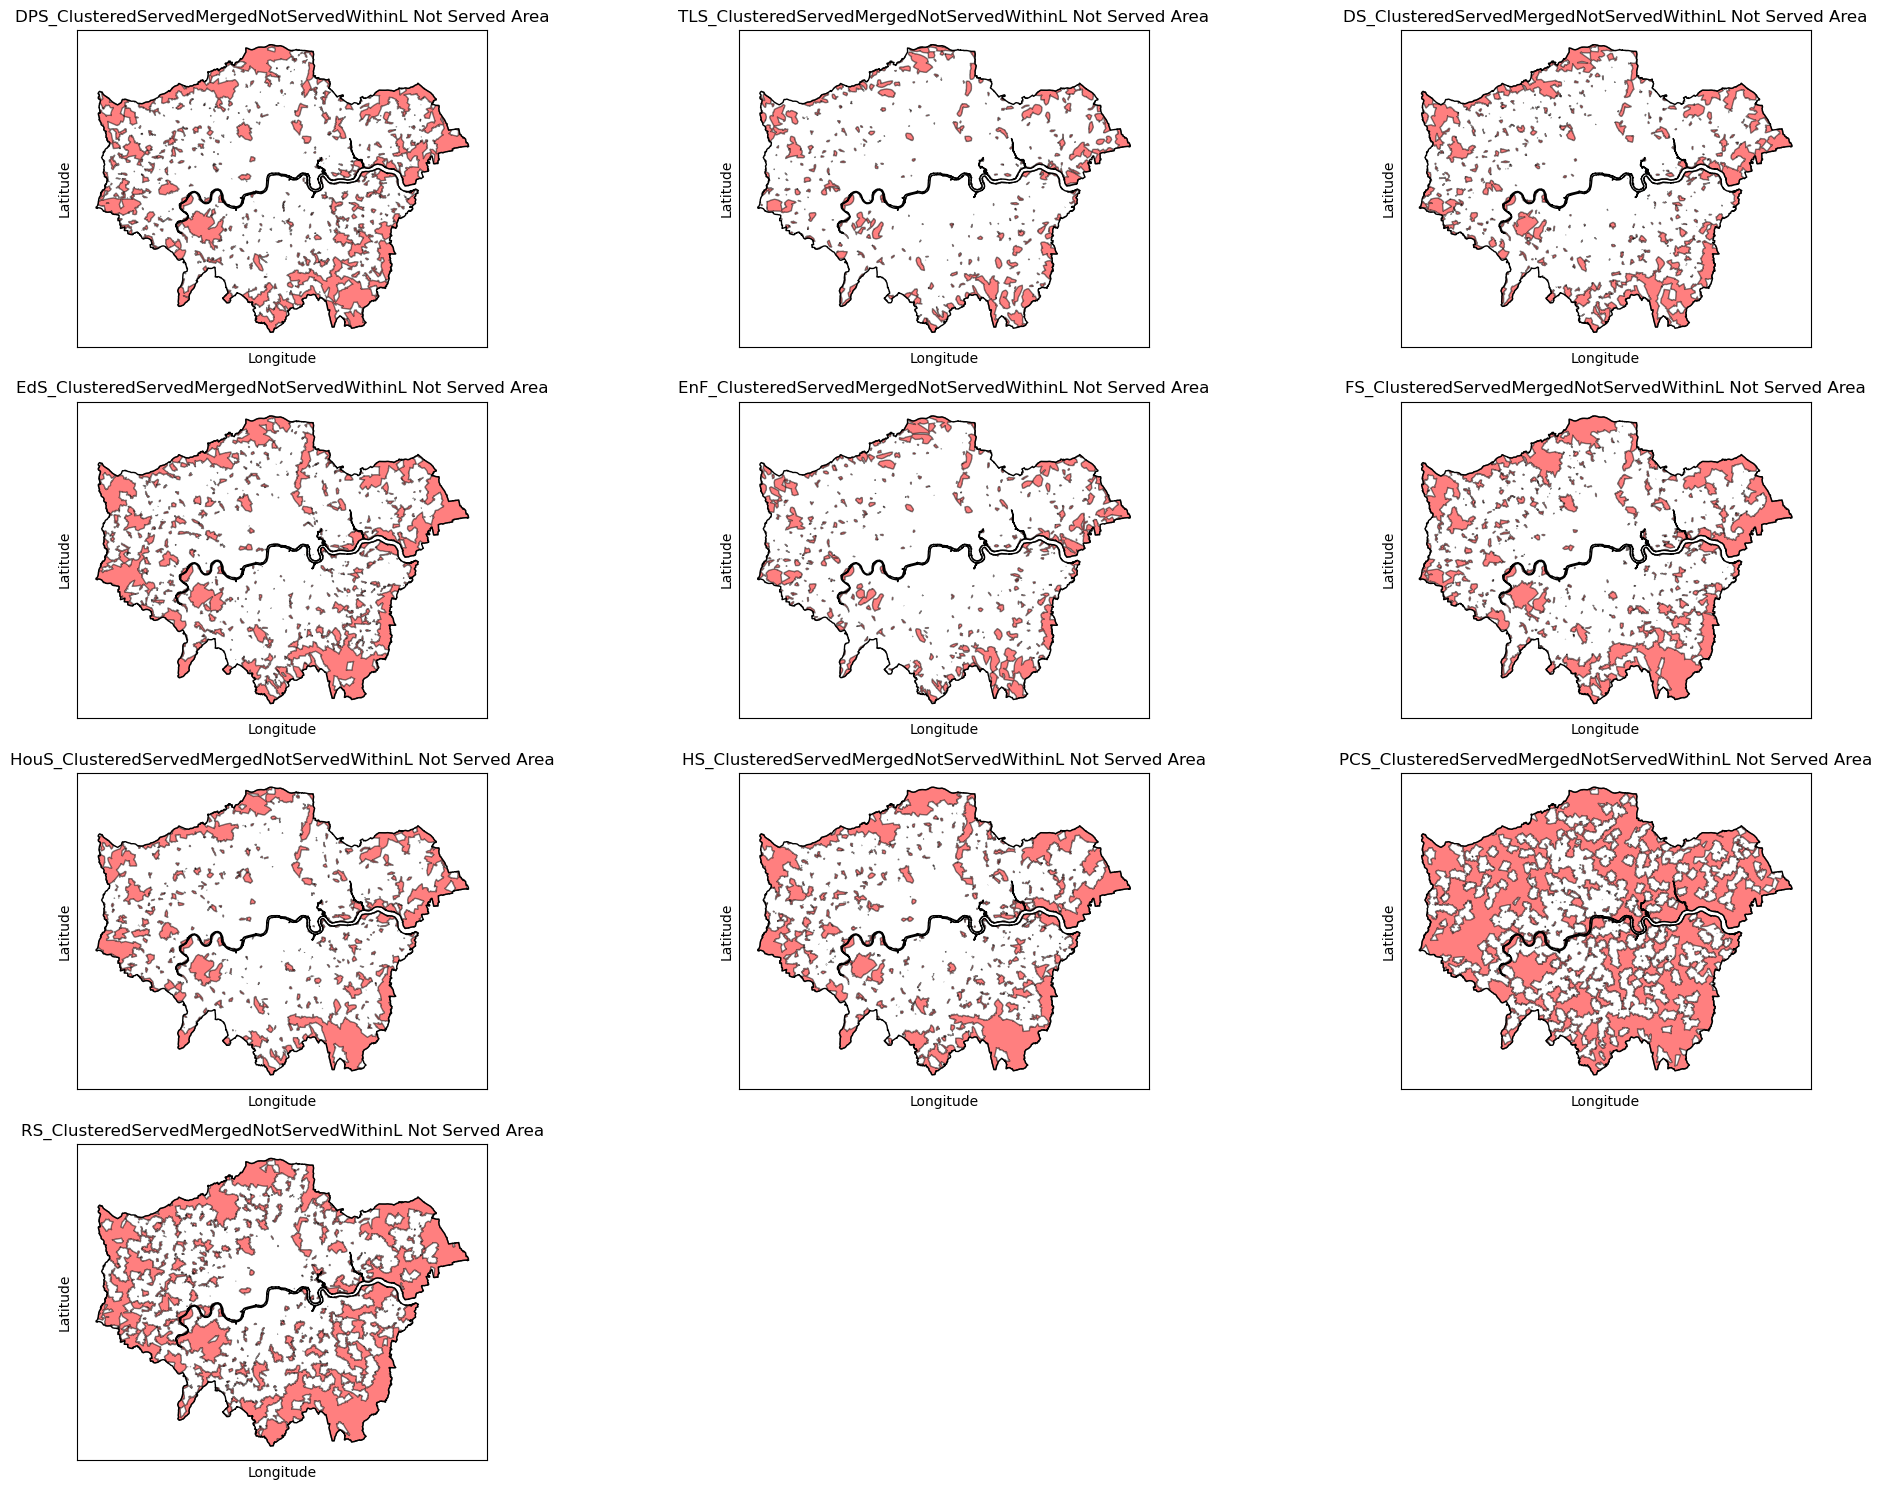

In [43]:
# 设置 3x4 的布局
fig, axes = plt.subplots(4, 3, figsize=(20, 15))

# 扁平化 axes 数组以便于迭代
axes = axes.flatten()

# 循环遍历每个生成的 GeoDataFrame 并绘制结果
for idx, (name, gdf) in enumerate(MergedNotServedGdfs.items()):
    if idx < len(axes):
        ax = axes[idx]
        
        # 绘制不服务区域的 GeoDataFrame
        gdf.plot(ax=ax, color='red', edgecolor='black', alpha=0.5)
        
        # 绘制 LondonBoundary 以进行比较
        LondonBoundary.boundary.plot(ax=ax, color='black', linewidth=1)
        
        # 设置标题
        ax.set_title(f"{name} Not Served Area")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        
        # 去除多余的轴标签
        ax.set_xticks([])
        ax.set_yticks([])

# 对于剩余的空子图，将其隐藏
for idx in range(len(MergedNotServedGdfs), len(axes)):
    fig.delaxes(axes[idx])

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

# 如果需要保存图像，可以使用以下代码
# plt.savefig("MergedNotServedAreas_3x4.png", dpi=300)

In [44]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 假设 MergedNotServedGdfs 和 Borough 是已经存在的 GeoDataFrames

# 循环遍历 MergedNotServedGdfs 中的每个 GeoDataFrame
for idx, (name, gdf) in MergedNotServedGdfs.items():
    print(f"Processing {name} for intersection with Boroughs...")

    # Step 3: 与 Borough 进行相交处理
    try:
        borough_intersection_gdf = gpd.overlay(not_served_gdf, Borough, how='intersection')
        print(f"Intersection completed for {name}. Resulting GeoDataFrame has {len(borough_intersection_gdf)} rows.")
    except Exception as e:
        print(f"Error during intersection for {name}: {e}")
        continue

    # 检查相交结果是否为空
    if borough_intersection_gdf.empty:
        print(f"No intersection found for {name}. Skipping plotting.")
        continue

    # 绘制结果，基于 Borough 的 NAME 列进行着色
    fig, ax = plt.subplots(figsize=(10, 10))
    try:
        borough_intersection_gdf.plot(ax=ax, column='NAME', cmap='tab20', edgecolor='black', alpha=0.7)
        Borough.boundary.plot(ax=ax, color='black', linewidth=1)
    
        # 设置标题和轴标签
        ax.set_title(f"{name} MergedNotServedWithinL in Boroughs")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
    
        # 显示图形
        plt.show(block=True)
        print(f"Plot displayed for {name}.")
    except Exception as e:
        print(f"Error during plotting for {name}: {e}")

    # 如果需要，可以保存绘制的图像或结果
    # plt.savefig(f"{name}_in_Boroughs.png", dpi=300)
    # borough_intersection_gdf.to_file(f"{name}_Borough_Intersection.shp")

ValueError: too many values to unpack (expected 2)

### 4.2.2 Population Coverage Development Potential

### 4.2.3 Area Coverage Development Potential

# 5 Discussion

In [ ]:
# 数据集
data = {
    'Label': ['DPS', 'HS', 'HouS', 'RS', 'EdS', 'TLS', 'FS', 'DS', 'EnF', 'PCS'],
    'POI Count': [10419, 10144, 10944, 10625, 5717, 30244, 12173, 53525, 29043, 996],
    'Service Coverage Rate': [76.40, 73.98, 76.40, 62.54, 75.06, 88.04, 74.38, 81.50, 86.60, 45.51],
    'SW': [0.81, 0.83, 0.81, 0.63, 0.81, 0.81, 0.83, 0.85, 0.87, 0.614],
    'Cluster Count': [45, 47, 45, 61, 49, 24, 44, 43, 41, 117]
}
df = pd.DataFrame(data)

# 1. 四维散点图 (3D with color as the fourth dimension)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 三个维度: POI Count, Service Coverage Rate, SW
sc = ax.scatter(df['POI Count'], df['Service Coverage Rate'], df['SW'], c=df['Cluster Count'], cmap='plasma', s=100)
ax.set_xlabel('POI Count')
ax.set_ylabel('Service Coverage Rate (%)')
ax.set_zlabel('SW')

# 添加颜色条来表示 Cluster Count
cbar = plt.colorbar(sc)
cbar.set_label('Cluster Count')

plt.title('4D Scatter Plot: POI Count vs Service Coverage Rate vs SW with Cluster Count as Color')
plt.savefig('Relationship_4D.png')
plt.show()

# 2. 二维散点图 (1x3 布局)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# POI Count vs Service Coverage Rate
scatter1 = axs[0].scatter(df['POI Count'], df['Service Coverage Rate'], c=df['Cluster Count'], cmap='plasma', s=100)
axs[0].set_title('POI Count vs Service Coverage Rate')
axs[0].set_xlabel('POI Count')
axs[0].set_ylabel('Service Coverage Rate (%)')
axs[0].set_ylim(0, 100)  # 设置 Service Coverage Rate 的 y 轴范围
cbar1 = plt.colorbar(scatter1, ax=axs[0])
cbar1.set_label('Cluster Count')

# POI Count vs SW
scatter2 = axs[1].scatter(df['POI Count'], df['SW'], c=df['Cluster Count'], cmap='plasma', s=100)
axs[1].set_title('POI Count vs SW')
axs[1].set_xlabel('POI Count')
axs[1].set_ylabel('SW')
axs[1].set_ylim(0, 1)  # 设置 SW 的 y 轴范围
cbar2 = plt.colorbar(scatter2, ax=axs[1])
cbar2.set_label('Cluster Count')

# POI Count vs Cluster Count
scatter3 = axs[2].scatter(df['POI Count'], df['Cluster Count'], c=df['Cluster Count'], cmap='plasma', s=100)
axs[2].set_title('POI Count vs Cluster Count')
axs[2].set_xlabel('POI Count')
axs[2].set_ylabel('Cluster Count')
cbar3 = plt.colorbar(scatter3, ax=axs[2])
cbar3.set_label('Cluster Count')

# 调整子图间距
plt.tight_layout()

# 保存为图像文件
plt.savefig('Relationship_2D.png')

plt.show()

# 6 Conclusion

### 1 DPS - Daily Professional Support - 10419/10551

#### 1.1 DPS Walkability

In [ ]:
# 定义要合并的 Shapefile 文件路径
DSPS_Served = gpd.read_file("10-5 Result/01DSPS_Served.shp")

# 裁剪 TLS_Served，使其只保留在 london_shapefile 范围内的几何数据
DSPS_ServedWithinL = gpd.clip(DSPS_Served, LondonBoundry)
DSPS_ServedWithinL

#### 1.2 DPS Coverage

#### 1.3 DPS Cluster

In [ ]:
# 创建一个空的列表来保存最终的合并结果
merged_polygons = []

# 初始化未合并的多边形列表
unmerged_polygons = list(DSPS_ServedWithinL.geometry)

# 迭代合并过程
while unmerged_polygons:
    polygon = unmerged_polygons.pop(0)
    merge_occurred = False
    
    for i in range(len(unmerged_polygons)):
        if (polygon.intersects(unmerged_polygons[i]) or
            polygon.touches(unmerged_polygons[i])):
            # 如果当前多边形与待处理列表中的多边形相交或接触，则合并
            polygon = unary_union([polygon, unmerged_polygons.pop(i)])
            merge_occurred = True
            break
    
    if merge_occurred:
        # 如果发生了合并，将合并后的多边形放回待处理列表继续处理
        unmerged_polygons.append(polygon)
    else:
        # 如果没有发生合并，则将多边形添加到合并结果列表中
        merged_polygons.append(polygon)

# 创建新的GeoDataFrame保存合并后的多边形
DSPS_ClusteredServed = gpd.GeoDataFrame(geometry=merged_polygons, crs=DSPS_ServedWithinL.crs)
DSPS_ClusteredServed

In [ ]:
merged_data_DSPS = process_shapefile("10-5 Result/01DSPS_Served.shp", LondonBoundry, "10-5 Result/01DSPS_ClusteredServed.shp")

In [ ]:
DSPS_ClusteredServed.to_file("10-5 Result/01DSPS_ClusteredServed.shp")

In [ ]:
plot_polygons(merged_data_DSPS, merged_data_DSPS)

In [ ]:
# 绘图
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# 在第一个子图上绘制原始多边形
DSPS_ClusteredServed.plot(ax=ax[0], edgecolor='black')
ax[0].set_title('Original Polygons')

# 在第二个子图上使用自带色斑绘制合并后的多边形
# 这里使用 'viridis' colormap，但你可以换成 'tab10', 'plasma', 'inferno', 等
DSPS_ClusteredServed.plot(cmap='viridis', ax=ax[1], edgecolor='black')
ax[1].set_title('Merged Polygons with Viridis Colormap')

plt.show()

#### 1.4 DPS Potential

### 2 HS - Healthcare Services - 10144/10273

#### 2.0 HMS Data

In [ ]:
# 定义要合并的 Shapefile 文件路径
HMS_Served = gpd.read_file("10-5 Result/02HMS_Served.shp")

# 裁剪 TLS_Served，使其只保留在 london_shapefile 范围内的几何数据
HMS_ServedWithinL = gpd.clip(HMS_Served, LondonBoundry)
HMS_ServedWithinL

#### 2.1 HMS Coverage

#### 2.2 HMS Cluster

In [ ]:
# 创建一个空的列表来保存最终的合并结果
merged_polygons = []

# 初始化未合并的多边形列表
unmerged_polygons = list(HMS_ServedWithinL.geometry)

# 迭代合并过程
while unmerged_polygons:
    polygon = unmerged_polygons.pop(0)
    merge_occurred = False
    
    for i in range(len(unmerged_polygons)):
        if (polygon.intersects(unmerged_polygons[i]) or
            polygon.touches(unmerged_polygons[i])):
            # 如果当前多边形与待处理列表中的多边形相交或接触，则合并
            polygon = unary_union([polygon, unmerged_polygons.pop(i)])
            merge_occurred = True
            break
    
    if merge_occurred:
        # 如果发生了合并，将合并后的多边形放回待处理列表继续处理
        unmerged_polygons.append(polygon)
    else:
        # 如果没有发生合并，则将多边形添加到合并结果列表中
        merged_polygons.append(polygon)
        
# 创建新的GeoDataFrame保存合并后的多边形
HMS_ClusteredServed = gpd.GeoDataFrame(geometry=merged_polygons, crs=HMS_ServedWithinL.crs)
HMS_ClusteredServed

In [ ]:
HMS_ClusteredServed.to_file("10-5 Result/02HMS_ClusteredServed.shp")

In [ ]:
# 绘图
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# 在第一个子图上绘制原始多边形
HMS_ClusteredServed.plot(ax=ax[0], edgecolor='black')
ax[0].set_title('Original Polygons')

# 在第二个子图上使用自带色斑绘制合并后的多边形
# 这里使用 'viridis' colormap，但你可以换成 'tab10', 'plasma', 'inferno', 等
HMS_ClusteredServed.plot(cmap='viridis', ax=ax[1], edgecolor='black')
ax[1].set_title('Merged Polygons with Viridis Colormap')

plt.show()

### 3 HouS - Housing Services - 10944/11144

#### 3.0 RHS Data

In [ ]:
# 定义要合并的 Shapefile 文件路径
RHS_Served = gpd.read_file("10-5 Result/03RHS_Served.shp")

# 裁剪 TLS_Served，使其只保留在 london_shapefile 范围内的几何数据
RHS_ServedWithinL = gpd.clip(RHS_Served, LondonBoundry)
RHS_ServedWithinL

#### 3.1 RHS Coverage

#### 3.2 RHS Cluster

In [ ]:
# 创建一个空的列表来保存最终的合并结果
merged_polygons = []

# 初始化未合并的多边形列表
unmerged_polygons = list(DSPS_ServedWithinL.geometry)

# 迭代合并过程
while unmerged_polygons:
    polygon = unmerged_polygons.pop(0)
    merge_occurred = False
    
    for i in range(len(unmerged_polygons)):
        if (polygon.intersects(unmerged_polygons[i]) or
            polygon.touches(unmerged_polygons[i])):
            # 如果当前多边形与待处理列表中的多边形相交或接触，则合并
            polygon = unary_union([polygon, unmerged_polygons.pop(i)])
            merge_occurred = True
            break
    
    if merge_occurred:
        # 如果发生了合并，将合并后的多边形放回待处理列表继续处理
        unmerged_polygons.append(polygon)
    else:
        # 如果没有发生合并，则将多边形添加到合并结果列表中
        merged_polygons.append(polygon)
        
# 创建新的GeoDataFrame保存合并后的多边形
RHS_ClusteredServed = gpd.GeoDataFrame(geometry=merged_polygons, crs=RHS_ServedWithinL.crs)
RHS_ClusteredServed

In [ ]:
RHS_ClusteredServed.to_file("10-5 Result/03RHS_ClusteredServed.shp")

In [ ]:
# 绘图
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# 在第一个子图上绘制原始多边形
RHS_ClusteredServed.plot(ax=ax[0], edgecolor='black')
ax[0].set_title('Original Polygons')

# 在第二个子图上使用自带色斑绘制合并后的多边形
# 这里使用 'viridis' colormap，但你可以换成 'tab10', 'plasma', 'inferno', 等
RHS_ClusteredServed.plot(cmap='viridis', ax=ax[1], edgecolor='black')
ax[1].set_title('Merged Polygons with Viridis Colormap')

plt.show()

### 4 RS - Retail Service - 10625/10687

#### 4.0 RCG Data

In [ ]:
# 定义要合并的 Shapefile 文件路径
RCG_Served = gpd.read_file("10-5 Result/04RCG_Served.shp")

# 裁剪 TLS_Served，使其只保留在 london_shapefile 范围内的几何数据
RCG_ServedWithinL = gpd.clip(RCG_Served, LondonBoundry)
RCG_ServedWithinL

#### 4.1 RCG Coverage

#### 4.2 RCG Cluster

In [ ]:
# 创建一个空的列表来保存最终的合并结果
merged_polygons = []

# 初始化未合并的多边形列表
unmerged_polygons = list(RCG_ServedWithinL.geometry)

# 迭代合并过程
while unmerged_polygons:
    polygon = unmerged_polygons.pop(0)
    merge_occurred = False
    
    for i in range(len(unmerged_polygons)):
        if (polygon.intersects(unmerged_polygons[i]) or
            polygon.touches(unmerged_polygons[i])):
            # 如果当前多边形与待处理列表中的多边形相交或接触，则合并
            polygon = unary_union([polygon, unmerged_polygons.pop(i)])
            merge_occurred = True
            break
    
    if merge_occurred:
        # 如果发生了合并，将合并后的多边形放回待处理列表继续处理
        unmerged_polygons.append(polygon)
    else:
        # 如果没有发生合并，则将多边形添加到合并结果列表中
        merged_polygons.append(polygon)
        
# 创建新的GeoDataFrame保存合并后的多边形
RCG_ClusteredServed = gpd.GeoDataFrame(geometry=merged_polygons, crs=RCG_ServedWithinL.crs)
RCG_ClusteredServed

In [ ]:
RCG_ClusteredServed.to_file("10-5 Result/04RCG_ClusteredServed.shp")

In [ ]:
# 绘图
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# 在第一个子图上绘制原始多边形
RCG_ClusteredServed.plot(ax=ax[0], edgecolor='black')
ax[0].set_title('Original Polygons')

# 在第二个子图上使用自带色斑绘制合并后的多边形
# 这里使用 'viridis' colormap，但你可以换成 'tab10', 'plasma', 'inferno', 等
RCG_ClusteredServed.plot(cmap='viridis', ax=ax[1], edgecolor='black')
ax[1].set_title('Merged Polygons with Viridis Colormap')

plt.show()

### 5 EdS - Educational Services - 5717/5801

#### 5.0 EFSS Data

In [ ]:
# 定义要合并的 Shapefile 文件路径
EFSS_Served = gpd.read_file("10-5 Result/05EFSS_Served.shp")

# 裁剪 TLS_Served，使其只保留在 london_shapefile 范围内的几何数据
EFSS_ServedWithinL = gpd.clip(EFSS_Served, LondonBoundry)
EFSS_ServedWithinL

#### 5.1 EFSS Coverage

#### 5.2 EFSS Cluster

In [ ]:
# 创建一个空的列表来保存最终的合并结果
merged_polygons = []

# 初始化未合并的多边形列表
unmerged_polygons = list(EFSS_ServedWithinL.geometry)

# 迭代合并过程
while unmerged_polygons:
    polygon = unmerged_polygons.pop(0)
    merge_occurred = False
    
    for i in range(len(unmerged_polygons)):
        if (polygon.intersects(unmerged_polygons[i]) or
            polygon.touches(unmerged_polygons[i])):
            # 如果当前多边形与待处理列表中的多边形相交或接触，则合并
            polygon = unary_union([polygon, unmerged_polygons.pop(i)])
            merge_occurred = True
            break
    
    if merge_occurred:
        # 如果发生了合并，将合并后的多边形放回待处理列表继续处理
        unmerged_polygons.append(polygon)
    else:
        # 如果没有发生合并，则将多边形添加到合并结果列表中
        merged_polygons.append(polygon)
        
# 创建新的GeoDataFrame保存合并后的多边形
EFSS_ClusteredServed = gpd.GeoDataFrame(geometry=merged_polygons, crs=EFSS_ServedWithinL.crs)
EFSS_ClusteredServed

In [ ]:
EFSS_ClusteredServed.to_file("10-5 Result/05EFSS_ClusteredServed.shp")

In [ ]:
# 绘图
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# 在第一个子图上绘制原始多边形
EFSS_ClusteredServed.plot(ax=ax[0], edgecolor='black')
ax[0].set_title('Original Polygons')

# 在第二个子图上使用自带色斑绘制合并后的多边形
# 这里使用 'viridis' colormap，但你可以换成 'tab10', 'plasma', 'inferno', 等
EFSS_ClusteredServed.plot(cmap='viridis', ax=ax[1], edgecolor='black')
ax[1].set_title('Merged Polygons with Viridis Colormap')

plt.show()

### 6 TLS - Transportation and Logistics Services - 30244/30814

#### 6.0 TLS Data

In [ ]:
# 定义要合并的 Shapefile 文件路径
TLS_ServedShapefile = ["10-5 Result/06TLS_Served1.shp", "10-5 Result/06TLS_Served2.shp","10-5 Result/06TLS_Served3.shp"]

# 读取并合并所有 Shapefile
TLS_ServedShapefiles = [gpd.read_file(shp) for shp in TLS_ServedShapefile]
TLS_Served = gpd.GeoDataFrame(pd.concat(TLS_ServedShapefiles, ignore_index=True))
TLS_Served

# 保存合并后的 Shapefile
# output_shapefile = "10-5 Result/06TLS_Served.shp"
# merged_gdf.to_file(output_shapefile)

In [ ]:
# 裁剪 TLS_Served，使其只保留在 london_shapefile 范围内的几何数据
TLS_ServedWithinL = gpd.clip(TLS_Served, LondonBoundry)
TLS_ServedWithinL

#### 6.1 TLS Coverage

#### 6.2 TLS Cluster

In [ ]:
# 创建一个空的列表来保存最终的合并结果
merged_polygons = []

# 初始化未合并的多边形列表
unmerged_polygons = list(TLS_ServedWithinL.geometry)

# 迭代合并过程
while unmerged_polygons:
    polygon = unmerged_polygons.pop(0)
    merge_occurred = False
    
    for i in range(len(unmerged_polygons)):
        if (polygon.intersects(unmerged_polygons[i]) or
            polygon.touches(unmerged_polygons[i])):
            # 如果当前多边形与待处理列表中的多边形相交或接触，则合并
            polygon = unary_union([polygon, unmerged_polygons.pop(i)])
            merge_occurred = True
            break
    
    if merge_occurred:
        # 如果发生了合并，将合并后的多边形放回待处理列表继续处理
        unmerged_polygons.append(polygon)
    else:
        # 如果没有发生合并，则将多边形添加到合并结果列表中
        merged_polygons.append(polygon)

# 创建新的GeoDataFrame保存合并后的多边形
TLS_ClusteredServed = gpd.GeoDataFrame(geometry=merged_polygons, crs=TLS_ServedWithinL.crs)
TLS_ClusteredServed

In [ ]:
TLS_ClusteredServed.to_file("10-5 Result/06TLS_ClusteredServed.shp")

In [ ]:
# 绘图
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# 在第一个子图上绘制原始多边形
TLS_ClusteredServed.plot(ax=ax[0], edgecolor='black')
ax[0].set_title('Original Polygons')

# 在第二个子图上使用自带色斑绘制合并后的多边形
# 这里使用 'viridis' colormap，但你可以换成 'tab10', 'plasma', 'inferno', 等
TLS_ClusteredServed.plot(cmap='viridis', ax=ax[1], edgecolor='black')
ax[1].set_title('Merged Polygons with Viridis Colormap')

plt.show()

### 7 FS - Financial and Banking Services - 12173/12294

#### 7.0 FBS Data

In [ ]:
# 定义要合并的 Shapefile 文件路径
FBS_Served = gpd.read_file("10-5 Result/07FBS_Served.shp")

# 裁剪 TLS_Served，使其只保留在 london_shapefile 范围内的几何数据
FBS_ServedWithinL = gpd.clip(FBS_Served, LondonBoundry)
FBS_ServedWithinL

#### 7.1 FBS Coverage

#### 7.2 FBS Cluster

In [ ]:
# 创建一个空的列表来保存最终的合并结果
merged_polygons = []

# 初始化未合并的多边形列表
unmerged_polygons = list(FBS_ServedWithinL.geometry)

# 迭代合并过程
while unmerged_polygons:
    polygon = unmerged_polygons.pop(0)
    merge_occurred = False
    
    for i in range(len(unmerged_polygons)):
        if (polygon.intersects(unmerged_polygons[i]) or
            polygon.touches(unmerged_polygons[i])):
            # 如果当前多边形与待处理列表中的多边形相交或接触，则合并
            polygon = unary_union([polygon, unmerged_polygons.pop(i)])
            merge_occurred = True
            break
    
    if merge_occurred:
        # 如果发生了合并，将合并后的多边形放回待处理列表继续处理
        unmerged_polygons.append(polygon)
    else:
        # 如果没有发生合并，则将多边形添加到合并结果列表中
        merged_polygons.append(polygon)
        
# 创建新的GeoDataFrame保存合并后的多边形
FBS_ClusteredServed = gpd.GeoDataFrame(geometry=merged_polygons, crs=FBS_ServedWithinL.crs)
FBS_ClusteredServed

In [ ]:
FBS_ClusteredServed.to_file("10-5 Result/07FBS_ClusteredServed.shp")

In [ ]:
# 绘图
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# 在第一个子图上绘制原始多边形
FBS_ClusteredServed.plot(ax=ax[0], edgecolor='black')
ax[0].set_title('Original Polygons')

# 在第二个子图上使用自带色斑绘制合并后的多边形
# 这里使用 'viridis' colormap，但你可以换成 'tab10', 'plasma', 'inferno', 等
FBS_ClusteredServed.plot(cmap='viridis', ax=ax[1], edgecolor='black')
ax[1].set_title('Merged Polygons with Viridis Colormap')

plt.show()

### 8 DS - Dining and Culinary Services - 53525/53928

#### 8.0 DCS Data

In [ ]:
# 定义要合并的 Shapefile 文件路径
DCS_ServedShapefile = ["10-5 Result/08DCS_Served1.shp", "10-5 Result/08DCS_Served2.shp", "10-5 Result/08DCS_Served3.shp", "10-5 Result/08DCS_Served4.shp", "10-5 Result/08DCS_Served5.shp"]

# 读取并合并所有 Shapefile
DCS_ServedShapefiles = [gpd.read_file(shp) for shp in DCS_ServedShapefile]
DCS_Served = gpd.GeoDataFrame(pd.concat(DCS_ServedShapefiles, ignore_index=True))
DCS_Served

# 保存合并后的 Shapefile
# output_shapefile = "10-5 Result/08DCS_Served.shp"
# merged_gdf.to_file(output_shapefile)

In [ ]:
# 裁剪 DCS_Served，使其只保留在 london_shapefile 范围内的几何数据
DCS_ServedWithinL = gpd.clip(DCS_Served, LondonBoundry)
DCS_ServedWithinL

In [ ]:
# DCS_ServedWithinL.to_file("10-5 Result/08DCS_ServedWithinL.shp")

#### 8.1 DCS Coverage

In [ ]:
# 进行自我叠加以获得面之间的交叉关系
intersection = gpd.overlay(DCS_ServedWithinL, DCS_ServedWithinL, how='intersection')
intersection
# intersection 现在包含了 DCS_ServedWithinL 中几何体之间的交叉区域

#### 8.2 DCS Cluster

In [ ]:
# 创建一个空的列表来保存最终的合并结果
merged_polygons = []

# 初始化未合并的多边形列表
unmerged_polygons = list(DCS_ServedWithinL.geometry)

# 迭代合并过程
while unmerged_polygons:
    polygon = unmerged_polygons.pop(0)
    merge_occurred = False
    
    for i in range(len(unmerged_polygons)):
        if (polygon.intersects(unmerged_polygons[i]) or
            polygon.touches(unmerged_polygons[i])):
            # 如果当前多边形与待处理列表中的多边形相交或接触，则合并
            polygon = unary_union([polygon, unmerged_polygons.pop(i)])
            merge_occurred = True
            break
    
    if merge_occurred:
        # 如果发生了合并，将合并后的多边形放回待处理列表继续处理
        unmerged_polygons.append(polygon)
    else:
        # 如果没有发生合并，则将多边形添加到合并结果列表中
        merged_polygons.append(polygon)

# 创建新的GeoDataFrame保存合并后的多边形
DCS_ClusteredServed = gpd.GeoDataFrame(geometry=merged_polygons, crs=DCS_ServedWithinL.crs)
DCS_ClusteredServed

In [ ]:
# 假设你已经有一个 GeoDataFrame 叫 PACS_ServedWithinL
# 使用 explode 方法将 MultiPolygon 拆分为多个 Polygon
DCS_ClusteredServed = DCS_ClusteredServed.explode(index_parts=False)

# 重置索引，如果你希望新的 GeoDataFrame 有一个干净的索引
DCS_ClusteredServed = DCS_ClusteredServed.reset_index(drop=True)
DCS_ClusteredServed

In [ ]:
DCS_ClusteredServed.to_file("10-5 Result/08DCS_ClusteredServed.shp")

In [ ]:
# 绘图
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# 在第一个子图上绘制原始多边形
DCS_ClusteredServed.plot(ax=ax[0], edgecolor='black')
ax[0].set_title('Original Polygons')

# 在第二个子图上使用自带色斑绘制合并后的多边形
# 这里使用 'viridis' colormap，但你可以换成 'tab10', 'plasma', 'inferno', 等
DCS_ClusteredServed.plot(cmap='viridis', ax=ax[1], edgecolor='black')
ax[1].set_title('Merged Polygons with Viridis Colormap')

plt.show()

### 9 EnF - Entertainment, Recreation, and Cultural Facilities - 29043/29550

#### 9.0 ERCF Data

In [ ]:
# 定义要合并的 Shapefile 文件路径
ERCF_ServedShapefile = ["10-5 Result/09ERCF_Served1.shp", "10-5 Result/09ERCF_Served2.shp","10-5 Result/09ERCF_Served3.shp"]

# 读取并合并所有 Shapefile
ERCF_ServedShapefiles = [gpd.read_file(shp) for shp in ERCF_ServedShapefile]
ERCF_Served = gpd.GeoDataFrame(pd.concat(ERCF_ServedShapefiles, ignore_index=True))
ERCF_Served

# 保存合并后的 Shapefile
# output_shapefile = "10-5 Result/09ERCF_Served.shp"
# merged_gdf.to_file(output_shapefile)

In [ ]:
# 裁剪 TLS_Served，使其只保留在 london_shapefile 范围内的几何数据
ERCF_ServedWithinL = gpd.clip(ERCF_Served, LondonBoundry)
ERCF_ServedWithinL

#### 9.1 ERCF Coverage

#### 9.2 ERCF Cluster

In [ ]:
# 创建一个空的列表来保存最终的合并结果
merged_polygons = []

# 初始化未合并的多边形列表
unmerged_polygons = list(ERCF_ServedWithinL.geometry)

# 迭代合并过程
while unmerged_polygons:
    polygon = unmerged_polygons.pop(0)
    merge_occurred = False
    
    for i in range(len(unmerged_polygons)):
        if (polygon.intersects(unmerged_polygons[i]) or
            polygon.touches(unmerged_polygons[i])):
            # 如果当前多边形与待处理列表中的多边形相交或接触，则合并
            polygon = unary_union([polygon, unmerged_polygons.pop(i)])
            merge_occurred = True
            break
    
    if merge_occurred:
        # 如果发生了合并，将合并后的多边形放回待处理列表继续处理
        unmerged_polygons.append(polygon)
    else:
        # 如果没有发生合并，则将多边形添加到合并结果列表中
        merged_polygons.append(polygon)

# 创建新的GeoDataFrame保存合并后的多边形
ERCF_ClusteredServed = gpd.GeoDataFrame(geometry=merged_polygons, crs=ERCF_ServedWithinL.crs)
ERCF_ClusteredServed

In [ ]:
ERCF_ClusteredServed.to_file("10-5 Result/09ERCF_ClusteredServed.shp")

In [ ]:
# 绘图
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# 在第一个子图上绘制原始多边形
ERCF_ClusteredServed.plot(ax=ax[0], edgecolor='black')
ax[0].set_title('Original Polygons')

# 在第二个子图上使用自带色斑绘制合并后的多边形
# 这里使用 'viridis' colormap，但你可以换成 'tab10', 'plasma', 'inferno', 等
ERCF_ClusteredServed.plot(cmap='viridis', ax=ax[1], edgecolor='black')
ax[1].set_title('Merged Polygons with Viridis Colormap')

plt.show()

### 10 PCS - Pet Care Services - 996/996

#### 10.0 PACS Data

In [ ]:
# 定义要合并的 Shapefile 文件路径
PACS_Served = gpd.read_file("10-5 Result/10PACS_Served.shp")

# 裁剪 TLS_Served，使其只保留在 london_shapefile 范围内的几何数据
PACS_ServedWithinL = gpd.clip(PACS_Served, LondonBoundry)
PACS_ServedWithinL

In [ ]:
PACS_ServedWithinL['geometry_type'] = PACS_ServedWithinL['geometry'].apply(lambda x: x.geom_type)

# 查看每种几何类型的数量
geometry_type_counts = PACS_ServedWithinL['geometry_type'].value_counts()
unique_geometry_types = PACS_ServedWithinL['geometry'].apply(lambda x: x.geom_type).unique()

print(unique_geometry_types)
print(geometry_type_counts)

#### 10.1 PACS Coverage

In [ ]:
# 进行自我叠加以获得面之间的交叉关系
PACS_Intersection = gpd.overlay(PACS_ServedWithinL, PACS_ServedWithinL, how='intersection')
PACS_Intersection
# intersection 现在包含了 DCS_ServedWithinL 中几何体之间的交叉区域

In [ ]:
import geopandas as gpd

# 使用 sjoin 找到彼此相交的几何体，使用 'predicate' 参数替代 'op'
intersecting_pairs = gpd.sjoin(PACS_Intersection, PACS_Intersection, how="inner", predicate="intersects")

# 过滤掉自身与自身的交叉
intersecting_pairs = intersecting_pairs[intersecting_pairs.index != intersecting_pairs['index_right']]

# 展示有交叉关系的几何对
intersecting_pairs


#### 10.2 PACS Cluster

In [ ]:
# 创建一个空的列表来保存最终的合并结果
merged_polygons = []

# 初始化未合并的多边形列表
unmerged_polygons = list(PACS_ServedWithinL.geometry)

# 迭代合并过程
while unmerged_polygons:
    polygon = unmerged_polygons.pop(0)
    merge_occurred = False
    
    for i in range(len(unmerged_polygons)):
        if (polygon.intersects(unmerged_polygons[i]) or
            polygon.touches(unmerged_polygons[i])):
            # 如果当前多边形与待处理列表中的多边形相交或接触，则合并
            polygon = unary_union([polygon, unmerged_polygons.pop(i)])
            merge_occurred = True
            break
    
    if merge_occurred:
        # 如果发生了合并，将合并后的多边形放回待处理列表继续处理
        unmerged_polygons.append(polygon)
    else:
        # 如果没有发生合并，则将多边形添加到合并结果列表中
        merged_polygons.append(polygon)

# 创建新的GeoDataFrame保存合并后的多边形
PACS_ServedWithinL = gpd.GeoDataFrame(geometry=merged_polygons, crs=PACS_ServedWithinL.crs)
PACS_ServedWithinL

In [ ]:
# 创建一个空的列表来保存最终的合并结果
merged_polygons = []

# 初始化未合并的多边形列表
unmerged_polygons = list(PACS_ServedWithinL.geometry)

# 迭代合并过程
while unmerged_polygons:
    polygon = unmerged_polygons.pop(0)
    merge_occurred = False
    
    for i in range(len(unmerged_polygons)):
        if (polygon.intersects(unmerged_polygons[i]) or
            polygon.touches(unmerged_polygons[i])):
            # 如果当前多边形与待处理列表中的多边形相交或接触，则合并
            polygon = unary_union([polygon, unmerged_polygons.pop(i)])
            merge_occurred = True
            break
    
    if merge_occurred:
        # 如果发生了合并，将合并后的多边形放回待处理列表继续处理
        unmerged_polygons.append(polygon)
    else:
        # 如果没有发生合并，则将多边形添加到合并结果列表中
        merged_polygons.append(polygon)

# 创建新的GeoDataFrame保存合并后的多边形
PACS_ClusteredServed = gpd.GeoDataFrame(geometry=merged_polygons, crs=PACS_ServedWithinL.crs)
PACS_ClusteredServed

In [ ]:
PACS_ClusteredServed.to_file("10-5 Result/10PACS_ClusteredServed.shp")

In [ ]:
# 绘图
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# 在第一个子图上绘制原始多边形
PACS_ClusteredServed.plot(ax=ax[0], edgecolor='black')
ax[0].set_title('Original Polygons')

# 在第二个子图上使用自带色斑绘制合并后的多边形
# 这里使用 'viridis' colormap，但你可以换成 'tab10', 'plasma', 'inferno', 等
PACS_ClusteredServed.plot(cmap='viridis', ax=ax[1], edgecolor='black')
ax[1].set_title('Merged Polygons with Viridis Colormap')

plt.show()

# Appendix

## Batch export PSD layers

In [ ]:
# 打开 PSD 文件
psd = PSDImage.open('F.psd')

# 遍历所有图层
for layer in psd:
    if layer.is_group():
        for child_layer in layer:
            # 导出每个子图层为 PNG
            if child_layer.is_visible():
                image = child_layer.composite()
                image.save(f"{child_layer.name}.png")

## Word count

In [ ]:
# 打开PDF文件
pdf_file_path = "Dissertation_Template (21).pdf"
pdf_file = open(pdf_file_path, "rb")
pdf_reader = PyPDF2.PdfReader(pdf_file)

# 提取第13页到第59页的文本内容
start_page = 13  # 0-indexed，所以第13页对应索引12
end_page = 83    # 0-indexed，所以第59页对应索引58

text = ""
for page_num in range(start_page, end_page + 1):
    page = pdf_reader.pages[page_num]
    text += page.extract_text()

# 关闭PDF文件
pdf_file.close()

# 统计提取文本中的单词数
word_count = len(text.split())
print(f"Word count: {word_count}")

In [ ]:
# 打开PDF文件
pdf_file_path = "Dissertation_Template (21).pdf"
pdf_file = open(pdf_file_path, "rb")
pdf_reader = PyPDF2.PdfReader(pdf_file)

# 提取第13页到第59页的文本内容
start_page = 13  # 0-indexed，所以第13页对应索引12
end_page = 83    # 0-indexed，所以第59页对应索引58

text = ""
for page_num in range(start_page, end_page + 1):
    page = pdf_reader.pages[page_num]
    page_text = page.extract_text()

    # 过滤表格和插图内容
    # 你可以根据具体情况调整以下正则表达式，以匹配表格名和插图名的格式
    page_text = re.sub(r'(Table\s+\d+[:]?.*?\n)', '', page_text, flags=re.IGNORECASE)  # 去除表格名
    page_text = re.sub(r'(Figure\s+\d+[:]?.*?\n)', '', page_text, flags=re.IGNORECASE)  # 去除插图名
    page_text = re.sub(r'(\bFigure\b|\bTable\b).*?(\n|\r\n|\r)', '', page_text, flags=re.IGNORECASE)  # 去除表格和插图相关的文本
    
    text += page_text

# 关闭PDF文件
pdf_file.close()

# 统计提取文本中的单词数
# 过滤掉可能的多余空白符
filtered_text = " ".join(text.split())
word_count = len(filtered_text.split())
print(f"Word count: {word_count}")

In [45]:
end_time = time.time()
run_time = end_time - start_time
print("Total run time: ", run_time, "seconds")

Total run time:  1317.7324919700623 seconds
